In [2]:
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seawater as sw
import cartopy.crs as ccrs                   # import projections
import cartopy.feature as cf                 # import features
import uuid
from scipy import interpolate
from scipy import signal
from glob import glob
from sklearn.linear_model import LinearRegression
from matplotlib import ticker, cm
import matplotlib.colors as colors
import datetime as dt
import scipy.ndimage

#create xarray dataset with saildrone filenames
#data directory for saildrone data
data_dir = 'C:/Users/gentemann/Google Drive/public/2019_saildrone/ATOMIC/saildrone_usv_data/'
saildrone_filenames = [x for x in glob(data_dir+'saildrone*.nc')]

#data direcgtory for temperature logger .csv files
data_dir = 'C:/Users/gentemann/Google Drive/public/2019_saildrone/ATOMIC/temp_log_proc/'
#adir_sbe='F:/data/cruise_data/saildrone/2020_atomic/temp_log_proc/'

#data direcgtory for temperature logger .csv files
figs_dir = 'C:/Users/gentemann/Google Drive/public/2019_saildrone/ATOMIC/figs/'

#get list of all filenames in directory
logger_filenames = [x for x in glob(data_dir+'*1_min*.nc')]
#print('number of file:',len(files))
#print(files)

In [404]:
#subroutines for calculating PSD & making plot

def spectrum(data_in):
    #calculate PSD for each USV
    data_all=[]
    for iusv in range(3):
        ds_usv = data_in.isel(trajectory=iusv)
        ds2 = ds_usv.assign_coords(dist_total = ds_usv.dist_total)
        ds3 = ds2.swap_dims({'time':'dist_total'})
        dist_interp = np.arange(ds2.dist_total[0],ds2.dist_total[-1],0.08)
        ds4 = ds3.interp(dist_total=dist_interp)
        den = ds4.density_mean.interpolate_na(dim='dist_total')
        den = den.where(np.isfinite(den),drop=True)
        ds4_detrend = signal.detrend(den)
        ds4_detrend_smooth = scipy.ndimage.filters.gaussian_filter1d(ds4_detrend, sigma=25)
        freq, Pxx_den = signal.periodogram(ds4_detrend_smooth,1/.080)  #fs = sampled at .08km or 80m
        freq2, Pxx_den2 = signal.welch(ds4_detrend_smooth,1/.080,nperseg=1024*30)  #fs = sampled at .08km or 80m
        if iusv==0:
            ps_all=Pxx_den[0:10000]
            ps_all_welch=Pxx_den2[0:10000]
        else:
            ps_all = np.vstack([ps_all,Pxx_den[0:10000]])
            ps_all_welch = np.vstack([ps_all_welch,Pxx_den2[0:10000]])    
    Pxx_den = np.mean(ps_all,axis=0)
    Pxx_den_welch = np.mean(ps_all_welch,axis=0)
    return freq,freq2,Pxx_den,Pxx_den_welch


def cal_pdf(data_in): 
    #make arrays for sampling at different length scales
    length_scale = np.arange(.1,100,1)
    # create the empty data arrays to store the normalized histograms (normalized the *100 for percentage count)
    xx_in = np.arange(0,.04,.001)
    xx_in2 = np.arange(0,.04-.001,.001)
    data = np.zeros((len(length_scale),len(xx_in2)))
    ddn=xr.DataArray(data,dims=('length_scale','gradx'),coords={'length_scale':length_scale,'gradx':xx_in2})
    for iusv in range(3):
        ds_usv = data_in.isel(trajectory=iusv)
        ds2 = ds_usv.assign_coords(dist_total = ds_usv.dist_total)  #add dist traveled coordinate
        ds3 = ds2.swap_dims({'time':'dist_total'})                  #swap from time to distance traveled
        for ilen2,len2 in enumerate(length_scale):
            dist_interp = np.arange(ds2.dist_total[0],ds2.dist_total[-1],len2)
            ds4 = ds3.interp(dist_total=dist_interp)       
            den_grad =  np.abs(np.gradient(ds4.density_mean)/len2)
            result,xx = np.histogram(den_grad,bins=xx_in)
            ddn[ilen2,:]=ddn[ilen2,:]+result
    for ilen2,len2 in enumerate(length_scale):
        ddn[ilen2,:]=ddn[ilen2,:]/sum(ddn[ilen2,:])*100  #normalize & turn into percent

    return ddn


def psd_fig(f,data_in,Pxx_den,text1,fout,ifit):
   
    length_scale = np.arange(.1,100,1)
    xx_in = np.arange(0,.04,.001)
    xx_in2 = np.arange(0,.04-.001,.001)
    print(len(length_scale),len(xx_in))
    fig = plt.figure(figsize=(14,10))
    tem=data_in
    tem = tem.where(tem>.003)
    Z=tem.T
    ax = plt.pcolormesh(length_scale,xx_in2,Z, norm=colors.LogNorm(vmin=Z.min(), vmax=Z.max()),vmin=.01,vmax=100,cmap='hot')
    plt.text(25,0.036,'(a)'+text1,fontsize=16,color='k')
    plt.xlabel('Length scale (km)',fontsize=16)
    plt.ylabel('Density gradient (kg m$^{-3}$ km$^{-1}$)',fontsize=16)
    cb = plt.colorbar()
    cb.set_label(label='Percent count',fontsize=16)

    plt.axes([.43, .57, .3, .3])

    #cal PSD
    #Pxx_den = np.mean(psd_in,axis=0)
    #f, Pxx_den = signal.periodogram(Pxx_den,1/.080)  #fs = sampled at .08km or 80m
    istart,iend=10,5550
    plt.loglog(f[istart:iend], Pxx_den[istart:iend])

    #linear regression to PSD
    istart,iend=8,ifit
    XX = np.log(f[istart:iend])
    YY = np.log(Pxx_den[istart:iend])
    reg = LinearRegression().fit(XX.reshape(-1, 1), YY)
    a = float(reg.coef_)
    b = -1*float(reg.intercept_)
    plt.loglog(f[istart:iend], f[istart:iend]**(a)/np.exp(b),'r') #test from fit
    slp_str = 'slope = '+"{:.1f}".format(a)
    plt.text(.02,10,slp_str,fontsize=16,color='r')
    plt.ylim([10e-6,10e1])
    plt.xlim([10e-4,10e-1])
    plt.xticks(ticks=[.001,.01,.1,1],labels=['1000','100','10','1'])

    plt.text(.001,20,'(b)',fontsize=16,color='k')
    #plt.xlabel('Wavenumber (cpkm)')
    plt.xlabel('Wavelength (km)')
    plt.ylabel('PSD ((kg m$^{-3}$)$^2$ cpkm$^{-1}$]')
    plt.grid()
    plt.savefig(figs_dir+fout)
    return


# Read in USV data for all 3 Saildrone
- caluclate density and wind speed
- caluclate distance between successive obs
- caluculate total cumulative distance
- switch from time to cumulative distance as index
- interpolate data onto grid


In [420]:
ds=[]
for iusv in range(3):
    fname=saildrone_filenames[iusv]
    ds_usv=xr.open_dataset(fname).isel(trajectory=0).swap_dims({'obs':'time'})
    ds_usv.close()
    ds_usv['wspd']=np.sqrt(ds_usv.UWND_MEAN**2+ds_usv.VWND_MEAN**2)   
    tem=sw.dens0(ds_usv.SAL_SBE37_MEAN,ds_usv.TEMP_SBE37_MEAN)
    ds_usv['density_mean']=xr.DataArray(tem,dims=('time'),coords={'time':ds_usv.time})
    tem=sw.alpha(ds_usv.SAL_SBE37_MEAN,ds_usv.TEMP_SBE37_MEAN,ds_usv.BARO_PRES_MEAN*0) #pressure =0 at surface
    ds_usv['alpha_ME']=xr.DataArray(tem,dims=('time'),coords={'time':ds_usv.time})
    tem=sw.beta(ds_usv.SAL_SBE37_MEAN,ds_usv.TEMP_SBE37_MEAN,ds_usv.BARO_PRES_MEAN*0) #pressure =0 at surface
    ds_usv['beta_MEAN']=xr.DataArray(tem,dims=('time'),coords={'time':ds_usv.time})
    ds_usv['latitude']=ds_usv.latitude.interpolate_na(dim='time')
    ds_usv['longitude']=ds_usv.longitude.interpolate_na(dim='time')
    xlat=ds_usv.latitude
    xlon=ds_usv.longitude
    dkm2 = abs(np.abs((((xlon[1:].data-xlon[0:-1].data)**2+(xlat[1:].data-xlat[0:-1].data)**2)**.5)*110.567*np.cos(np.pi*xlat[1:].data/180)))
    dkm2=np.append(dkm2,dkm2[66238]) #add on last point
    dkm3 = dkm2.cumsum()
    ds_usv['dist_total']=xr.DataArray(dkm3,dims=('time'),coords={'time':ds_usv.time})
    ds_usv['dist_between']=xr.DataArray(dkm2,dims=('time'),coords={'time':ds_usv.time})
    if iusv==0:
        ds = ds_usv
    else:
        ds = xr.concat([ds,ds_usv],dim='trajectory')
ds_saildrone = ds.copy(deep=True)

#read in temperature loggers
ds_log = xr.open_mfdataset(data_dir+'*1_minute-v1.nc',combine='nested',concat_dim='trajectory')
ds_log.close()


# print out difference between two salinity sensors

In [239]:
# SBE37 minus RBR
dd=[]
for iusv in range(3):
    ds_usv=ds.isel(trajectory=iusv)
    dif = ds_usv.SAL_SBE37_MEAN-ds_usv.SAL_RBR_MEAN
    difm = dif.mean().data
    difs = dif.std().data
    print(ds_usv.trajectory.data,"{:.2f}".format(difm),"{:.2f}".format(difs),np.isfinite(dif).sum().data)
    if iusv==0:
        dd=ds_usv.SAL_SBE37_MEAN.data
    else:
        dd = np.concatenate([dd,ds_usv.SAL_SBE37_MEAN.data])
print("{:.2f}".format(np.nanmean(dd)),"{:.2f}".format(np.nanstd(dd)),np.isfinite(dd).sum())
    
# SBE37 minus RBR
dd=[]
for iusv in range(3):
    ds_usv=ds.isel(trajectory=iusv)
    dif = ds_usv.TEMP_SBE37_MEAN-ds_usv.TEMP_CTD_RBR_MEAN
    difm = dif.mean().data
    difs = dif.std().data
    print(ds_usv.trajectory.data,"{:.2f}".format(difm),"{:.2f}".format(difs),np.isfinite(dif).sum().data)
    if iusv==0:
        dd=ds_usv.SAL_SBE37_MEAN.data
    else:
        dd = np.concatenate([dd,ds_usv.SAL_SBE37_MEAN.data])
print("{:.2f}".format(np.nanmean(dd)),"{:.2f}".format(np.nanstd(dd)),np.isfinite(dd).sum())
    
# SBE37 minus RBR
dd=[]
for iusv in range(3):
    ds_usv=ds.isel(trajectory=iusv)
    dif = ds_usv.CHLOR_WETLABS_MEAN-ds_usv.CHLOR_RBR_MEAN
    difm = dif.mean().data
    difs = dif.std().data
    print(ds_usv.trajectory.data,"{:.2f}".format(difm),"{:.2f}".format(difs),np.isfinite(dif).sum().data)
    if iusv==0:
        dd=ds_usv.SAL_SBE37_MEAN.data
    else:
        dd = np.concatenate([dd,ds_usv.SAL_SBE37_MEAN.data])
print("{:.2f}".format(np.nanmean(dd)),"{:.2f}".format(np.nanstd(dd)),np.isfinite(dd).sum())

# SBE37 minus RBR
dd=[]
for iusv in range(3):
    ds_usv=ds.isel(trajectory=iusv)
    dif = ds_usv.O2_CONC_SBE37_MEAN-ds_usv.O2_CONC_RBR_MEAN 
    difm = dif.mean().data
    difs = dif.std().data
    print(ds_usv.trajectory.data,"{:.2f}".format(difm),"{:.2f}".format(difs),np.isfinite(dif).sum().data)
    if iusv==0:
        dd=ds_usv.SAL_SBE37_MEAN.data
    else:
        dd = np.concatenate([dd,ds_usv.SAL_SBE37_MEAN.data])
print("{:.2f}".format(np.nanmean(dd)),"{:.2f}".format(np.nanstd(dd)),np.isfinite(dd).sum())

    

1026 0.05 0.00 66183
1060 0.06 0.01 66183
1061 0.06 0.01 66183
35.87 0.60 198549
1026 -0.00 0.00 66183
1060 0.01 0.01 66183
1061 0.00 0.01 66183
35.87 0.60 198549
1026 -0.17 2.44 66183
1060 -0.26 1.18 66183
1061 -0.26 0.24 66183
35.87 0.60 198549
1026 4.63 0.91 66183
1060 3.84 2.43 66183
1061 -2.60 8.30 66183
35.87 0.60 198549


In [241]:
ds_usv=ds.isel(trajectory=0)
print(ds_usv.time[0].data,ds_usv.time[-1])

2020-01-17T00:00:00.000000000 <xarray.DataArray 'time' ()>
array('2020-03-02T23:59:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time        datetime64[ns] 2020-03-02T23:59:00
    latitude    float64 9.469
    longitude   float64 -51.29
    trajectory  <U4 '1026'
Attributes:
    standard_name:  time
    long_name:      time in seconds
    axis:           T


100 40


IndexError: invalid index to scalar variable.

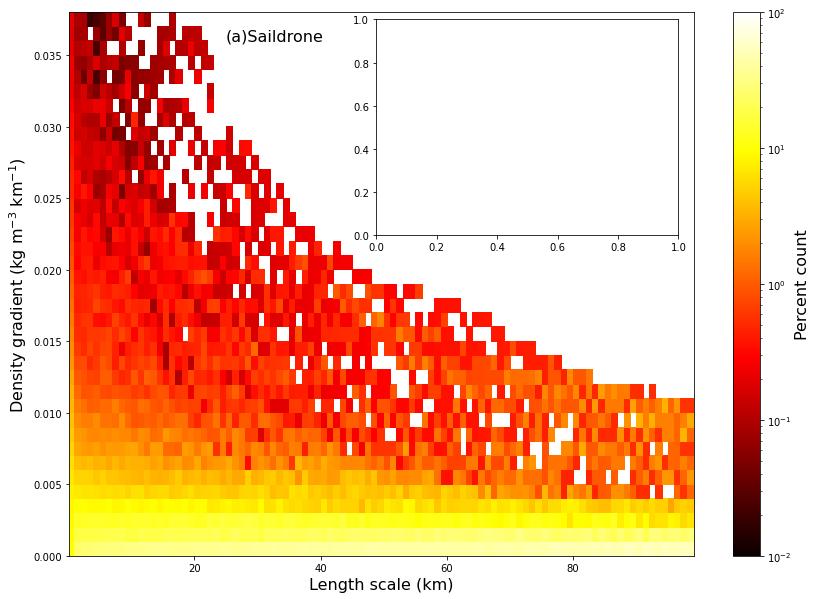

In [356]:
#call PSD figure Saildrones
freq,freq2,Pxx_den,Pxx_den_welch = spectrum(ds)
ddn = cal_pdf(ds)
#freq,ps_all,Pxx_den,ddn = cal_psd(ds)
psd_fig(freq,ddn,Pxx_den,'Saildrone','PSD_den_grad.png')


# read in satellite data

In [7]:
t1,t2=dt.datetime(2020,1,17),dt.datetime(2020,3,7)
fnames=[]
for i in range(46):
    t=t1+dt.timedelta(days=i)
    tdir = t-dt.timedelta(days=4)
    sdoy = str(tdir.timetuple().tm_yday).zfill(3)
    smon = str(t.month).zfill(2)
    sdy  = str(t.day).zfill(2)
    fname = 'Z:/SalinityDensity/smap/L3/JPL/V4.3/8day_running/2020/' + sdoy + '/SMAP_L3_SSS_2020'+smon+sdy+'_8DAYS_V4.3.nc'
    fnames.append(fname)
tem = xr.open_mfdataset(fnames,combine='nested',concat_dim='time')
tem = tem.rename({'latitude':'lat','longitude':'lon'}).sel(lon=slice(-64,-46),lat=slice(16,4))
ds_jpl = tem.load()

In [8]:
t1,t2=dt.datetime(2020,1,17),dt.datetime(2020,3,7)
fnames=[]
for i in range(46):
    t=t1+dt.timedelta(days=i)
    tdir = t-dt.timedelta(days=4)
    sdoy = str(tdir.timetuple().tm_yday).zfill(3)
    sdoy2 = str(t.timetuple().tm_yday).zfill(3)
    fname = 'F:/data/sat_data/smap/SSS/L3/RSS/V4/8day_running/SCI/2020/' + sdoy + '/RSS_smap_SSS_L3_8day_running_2020_'+sdoy2+'_FNL_v04.0.nc'
#    fname = 'Z:/SalinityDensity/smap/L3/RSS/V4/8day_running/SCI/2020/' + sdoy + '/RSS_smap_SSS_L3_8day_running_2020_'+sdoy2+'_FNL_v04.0.nc'
    fnames.append(fname)
tem = xr.open_mfdataset(fnames,combine='nested',concat_dim='time')
tem.coords['lon'] = (tem.coords['lon'] + 180) % 360 - 180
tem = tem.sortby(tem.lon)
tem = tem.sel(lon=slice(-64,-46),lat=slice(4,16))
ds_rss = tem.load()

# Make map

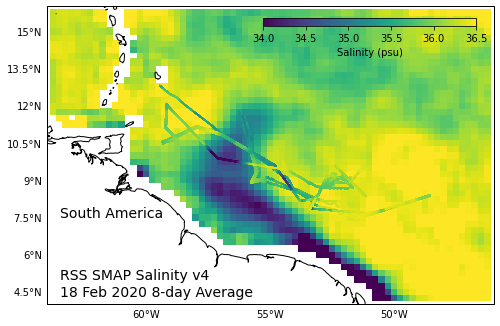

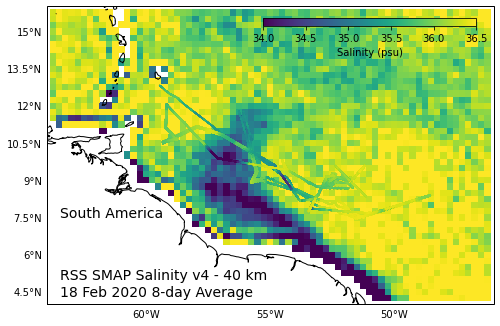

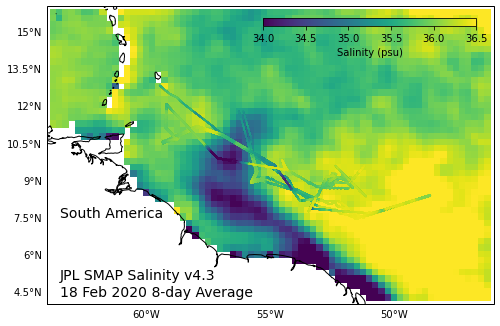

In [232]:
def map_fig(ds_sat,var,text1,text2,fout):
    fig = plt.figure(figsize=(8,6))
    ax = plt.axes(projection = ccrs.PlateCarree())  # create a set of axes with Mercator projection
    im=ax.pcolormesh(ds_sat.lon,ds_sat.lat,ds_sat[var],vmin=34,vmax=36.5,transform=ccrs.PlateCarree(),cmap='viridis')
    for i in range(3):
        ds2 = ds.isel(trajectory=i)
        ax.scatter(ds2.longitude,ds2.latitude,c=ds2.SAL_SBE37_MEAN,vmin=34,vmax=36.5,
                      s=.15,transform=ccrs.PlateCarree(),label=ds2.trajectory.data,cmap='viridis')

    ax.coastlines(resolution='10m')                
    ax.set_extent([-64,-46,4,16])
    bx1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                      linewidth=0, color='grey', alpha=0.5, linestyle='--')
    bx1.xlabels_top = False; bx1.ylabels_left = True
    bx1.ylabels_right = False; bx1.xlines = False
    bx1.xlocator = mticker.FixedLocator([-60,-55,-50,-45])
    bx1.xformatter = LONGITUDE_FORMATTER; bx1.yformatter = LATITUDE_FORMATTER

    #ax.legend()
    ax.text(-63.5,7.5,'South America',fontsize=14)
    ax.text(-63.5,5,text1,fontsize=14)
    ax.text(-63.5,4.3,text2,fontsize=14)
    cax = fig.add_axes([0.5, 0.8, 0.37, 0.02])
    cbar = fig.colorbar(im,cax=cax, orientation='horizontal')
    cbar.set_label('Salinity (psu)')
    fig.savefig(figs_dir+fout)     

text1='RSS SMAP Salinity v4'
text2='18 Feb 2020 8-day Average'
map_fig(ds_rss.sel(time='2020-02-18T12'),'sss_smap',text1,text2,'map_sss_rss_smap.png')

text1='RSS SMAP Salinity v4 - 40 km'
text2='18 Feb 2020 8-day Average'
map_fig(ds_rss.sel(time='2020-02-18T12'),'sss_smap_40km',text1,text2,'map_sss_rss_smap40km.png')

text1='JPL SMAP Salinity v4.3'
text2='18 Feb 2020 8-day Average'
map_fig(ds_jpl.sel(time='2020-02-18T12'),'smap_sss',text1,text2,'map_sss_jpl_smap.png')

# print stats

In [242]:
ds

<xarray.Dataset>
Dimensions:                         (time: 66240, trajectory: 3)
Coordinates:
  * time                            (time) datetime64[ns] 2020-01-17 ... 2020-03-02T23:59:00
    latitude                        (trajectory, time) float64 11.77 ... 9.193
    longitude                       (trajectory, time) float64 -56.28 ... -52.02
  * trajectory                      (trajectory) object '1026' '1060' '1061'
Data variables:
    SOG                             (trajectory, time) float64 2.214 ... 1.587
    SOG_FILTERED_MEAN               (trajectory, time) float64 1.894 ... 1.678
    SOG_FILTERED_STDDEV             (trajectory, time) float64 0.251 ... 0.299
    SOG_FILTERED_MAX                (trajectory, time) float64 2.597 ... 2.539
    SOG_FILTERED_MIN                (trajectory, time) float64 1.465 ... 1.027
    COG                             (trajectory, time) float64 153.7 ... 318.1
    COG_FILTERED_MEAN               (trajectory, time) float64 160.0 ... 318.8
    COG_FILTERED_STDDEV             (trajectory, time) float64 12.3 ... 14.1
    HDG                             (trajectory, time) float64 152.0 ... 311.9
    HDG_FILTERED_MEAN               (trajectory, time) float64 148.3 ... 310.2
    HDG_FILTERED_STDDEV             (trajectory, time) float64 0.0 0.0 ... 0.0
    ROLL_FILTERED_MEAN              (trajectory, time) float64 11.9 -2.8 ... 2.9
    ROLL_FILTERED_STDDEV            (trajectory, time) float64 0.0 0.0 ... 0.0
    ROLL_FILTERED_PEAK              (trajectory, time) float64 11.9 -2.8 ... 2.9
    PITCH_FILTERED_MEAN             (trajectory, time) float64 9.3 -1.0 ... -3.2
    PITCH_FILTERED_STDDEV           (trajectory, time) float64 0.0 0.0 ... 0.0
    PITCH_FILTERED_PEAK             (trajectory, time) float64 9.3 -1.0 ... -3.2
    HDG_WING                        (trajectory, time) float64 103.3 ... 51.7
    WING_HDG_FILTERED_MEAN          (trajectory, time) float64 99.6 ... 52.5
    WING_HDG_FILTERED_STDDEV        (trajectory, time) float64 3.8 4.7 ... 4.5
    WING_ROLL_FILTERED_MEAN         (trajectory, time) float64 3.3 3.6 ... 0.0
    WING_ROLL_FILTERED_STDDEV       (trajectory, time) float64 3.4 4.8 ... 3.1
    WING_ROLL_FILTERED_PEAK         (trajectory, time) float64 nan nan ... nan
    WING_PITCH_FILTERED_MEAN        (trajectory, time) float64 3.7 3.7 ... 1.0
    WING_PITCH_FILTERED_STDDEV      (trajectory, time) float64 5.3 4.4 ... 6.9
    WING_PITCH_FILTERED_PEAK        (trajectory, time) float64 15.8 ... 19.5
    WING_ANGLE                      (trajectory, time) float64 -48.8 ... 99.9
    UWND_MEAN                       (trajectory, time) float64 -8.51 ... -7.47
    UWND_STDDEV                     (trajectory, time) float64 0.61 0.6 ... 0.51
    VWND_MEAN                       (trajectory, time) float64 -1.83 ... -1.53
    VWND_STDDEV                     (trajectory, time) float64 0.59 ... 0.48
    WWND_MEAN                       (trajectory, time) float64 -0.1 ... -0.12
    WWND_STDDEV                     (trajectory, time) float64 0.32 ... 0.33
    GUST_WND_MEAN                   (trajectory, time) float64 9.7 8.82 ... 8.36
    GUST_WND_STDDEV                 (trajectory, time) float64 0.5 0.48 ... 0.36
    WIND_MEASUREMENT_HEIGHT_MEAN    (trajectory, time) float64 4.947 ... 4.946
    WIND_MEASUREMENT_HEIGHT_STDDEV  (trajectory, time) float64 0.059 ... 0.06
    TEMP_AIR_MEAN                   (trajectory, time) float64 26.98 ... 26.12
    TEMP_AIR_STDDEV                 (trajectory, time) float64 0.03 ... 0.04
    RH_MEAN                         (trajectory, time) float64 79.77 ... 78.45
    RH_STDDEV                       (trajectory, time) float64 0.49 ... 0.46
    BARO_PRES_MEAN                  (trajectory, time) float64 1.016e+03 ... 1.014e+03
    BARO_PRES_STDDEV                (trajectory, time) float64 0.06 ... 0.06
    PAR_AIR_MEAN                    (trajectory, time) float64 0.0 0.0 ... 0.0
    PAR_AIR_STDDEV                  (trajectory, time) float64 0.0 0.0 ... 0.0
  

In [64]:
def print_stats(tstr,ds_sat2,var,ds_in,varsst,varden):
    import xarray
    import seawater as sw
    print('******'+tstr+'*******')
    for iusv in range(3):
        ds_usv = ds_in.isel(trajectory=iusv)
        tem = ds_sat2.interp(time=ds_usv.time,lat=ds_usv.latitude,lon=ds_usv.longitude)
        dif = tem[var]-ds_usv.SAL_SBE37_MEAN
        difm = dif.mean().data
        difs = dif.std().data
        print(iusv,"{:.2f}".format(difm),"{:.2f}".format(difs),np.isfinite(dif).sum().data)
        tem2=sw.dens0(tem[var],tem[varsst]-273.15) #ds.TEMP_SBE37_MEAN[iusv,:])
        tem[varden]=xr.DataArray(tem2.data,dims=('time'),coords={'time':ds_usv.time})
        tem['dist_total']=xr.DataArray(ds_usv.dist_total.data,dims=('time'),coords={'time':ds_usv.time})
        if iusv==0:
            ds_out = tem
        else:
            ds_out = xr.concat([ds_out,tem],dim='trajectory')
    return ds_out

ds_rss_usv = print_stats('RSS',ds_rss,'sss_smap',ds,'surtep','density_mean')
ds_rss_usv40 = print_stats('RSS40km',ds_rss,'sss_smap_40km',ds,'surtep','density_mean')
ds_jpl_usv = print_stats('JPL',ds_jpl,'smap_sss',ds,'anc_sst','density_mean')


******RSS*******
0 0.27 0.26 64744
1 0.28 0.26 64744
2 0.27 0.25 64744
******RSS40km*******
0 0.27 0.26 64744
1 0.28 0.27 64744
2 0.26 0.26 64744
******JPL*******
0 0.16 0.24 64744
1 0.16 0.25 64744
2 0.16 0.23 64744


# print eddy TS

3567.339265632886 4276.974209229797
['3750', '3850', '3950', '4050', '4150', '4250', '4350']
[0.    0.166 0.332 0.498 0.664 0.83  0.996]


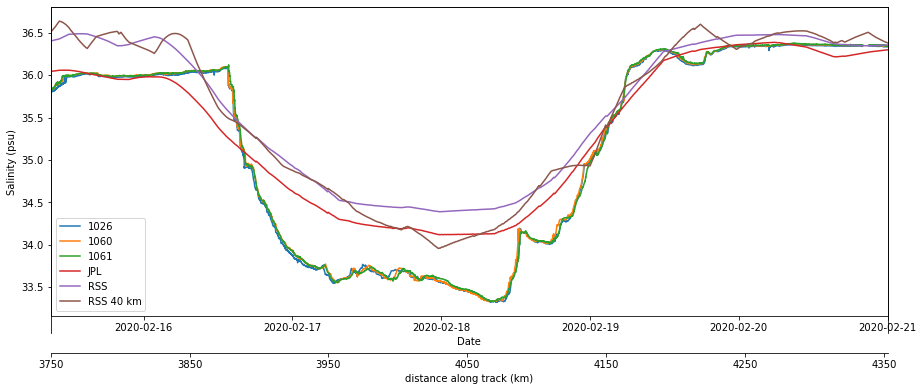

In [11]:
iusv=0
ds_usv = ds.isel(trajectory=iusv).sel(time=slice('2020-02-15T09','2020-02-21T0029'))
print(ds_usv.dist_total[0].data,ds_usv.dist_total[-1].data)
ll=[]
for i in range(3750,4450,100):
    ll.append("{:.0f}".format(i))
print(ll)
fig,(ax0)= plt.subplots(1,1,figsize=(15,6))
t1,t2='2020-02-15T09','2020-02-21T00'
for iusv in range(3):
    ds_usv = ds.isel(trajectory=iusv).sel(time=slice(t1,t2))
    ax0.plot(ds_usv.time,ds_usv.SAL_SBE37_MEAN,label=ds_usv.trajectory.data)
ds_usv = ds_jpl_usv.isel(trajectory=0).sel(time=slice(t1,t2))
ax0.plot(ds_usv.time,ds_usv.smap_sss,label='JPL')
ds_usv = ds_rss_usv.isel(trajectory=0).sel(time=slice(t1,t2))
ax0.plot(ds_usv.time,ds_usv.sss_smap,label='RSS')
ax0.plot(ds_usv.time,ds_usv.sss_smap_40km,label='RSS 40 km')
ax0.legend()
ax0.set_ylabel('Salinity (psu)')
ax0.set_xlabel('Date')
ax0.set_xlim([np.datetime64(t1),np.datetime64(t2)])

pos = ax0.get_position()
pos.y0 = pos.y0+.04       # for example 0.2, choose your value
ax0.set_position(pos)
#handles, labels = ax.get_legend_handles_labels()
#ax0.get_xticklabels(), ha="right", rotation=45)
ax2 = ax0.twiny()
# Add some extra space for the second axis at the bottom
#fig.subplots_adjust(bottom=0.2)
# Move twinned axis ticks and label from top to bottom
ax2.xaxis.set_ticks_position("bottom")
ax2.xaxis.set_label_position("bottom")
# Offset the twin axis below the host
ax2.spines["bottom"].set_position(("axes", -0.06))
ax1Ticks = ax0.get_xticks()   
ax2Ticks = ax1Ticks
new_tick_locations = np.arange(0,1,0.166)
print(new_tick_locations)
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(ll)
ax2.set_xlabel('distance along track (km)')
#labels = [item.get_text() for item in ax0.get_xticklabels()]
#ax0.set_xticklabels(labels,rotation=45) 
plt.savefig(figs_dir+'timeseries_eddy.png')
    

100 40
100 40
100 40
100 40


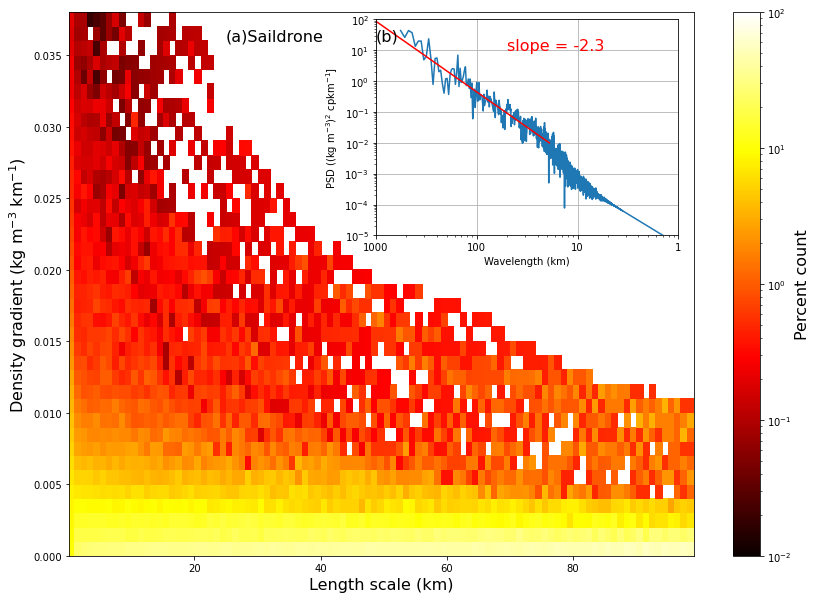

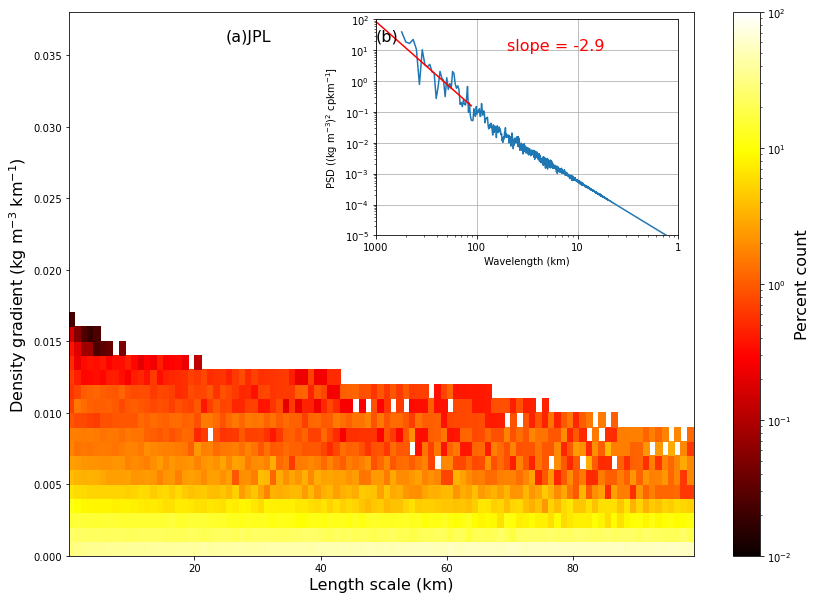

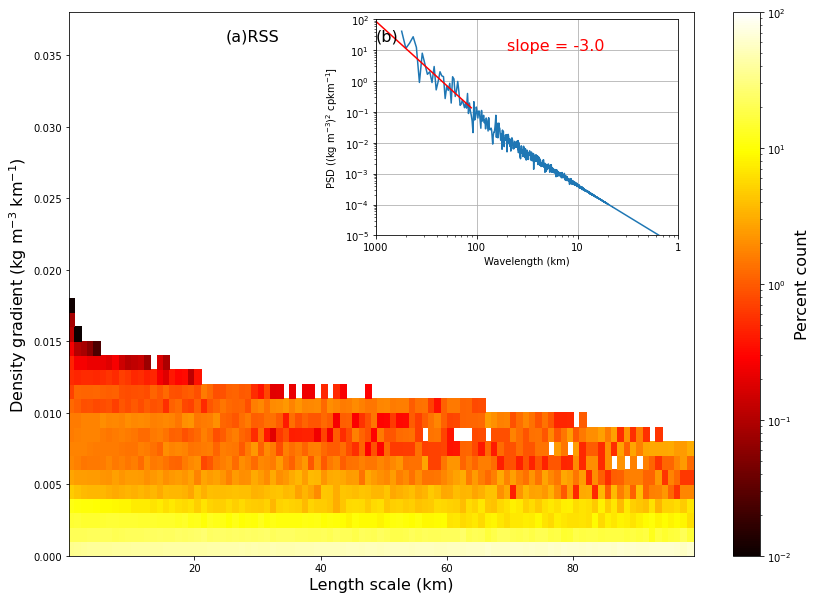

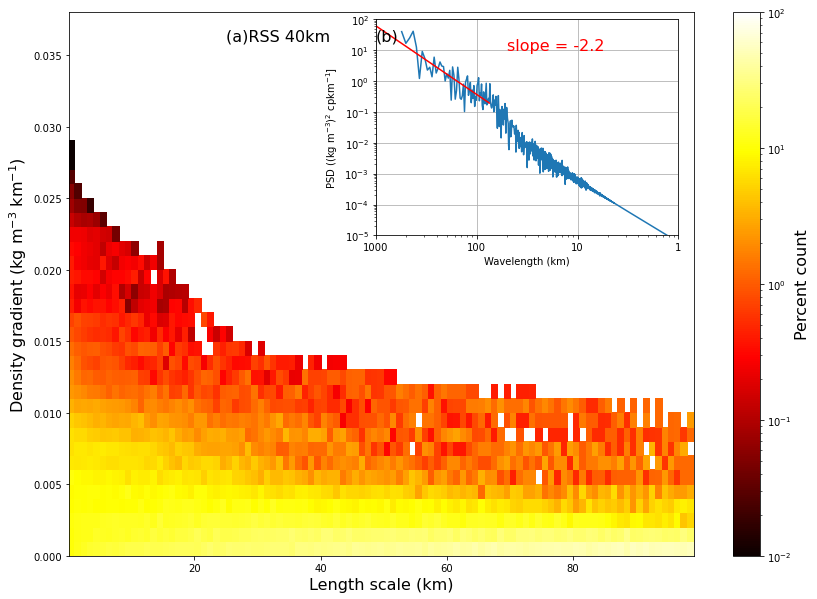

In [402]:

freq_usv,freq2_usv,Pxx_den_usv,Pxx_den_welch_usv = spectrum(ds)
freq_jpl,freq2_jpl,Pxx_den_jpl,Pxx_den_welch_jpl = spectrum(ds_jpl_usv)
freq_rss,freq2_rss,Pxx_den_rss,Pxx_den_welch_rss = spectrum(ds_rss_usv)
freq_rss4,freq2_rss4,Pxx_den_rss4,Pxx_den_welch_rss4 = spectrum(ds_rss_usv40)

ddn_usv = cal_pdf(ds)
ddn_jpl = cal_pdf(ds_jpl_usv)
ddn_rss = cal_pdf(ds_rss_usv)
ddn_rss4 = cal_pdf(ds_rss_usv40)



100 40
100 40


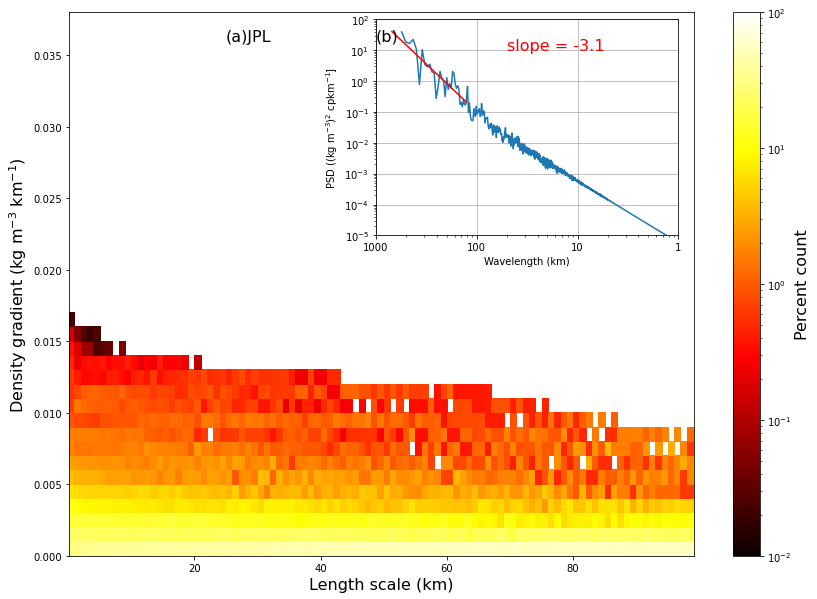

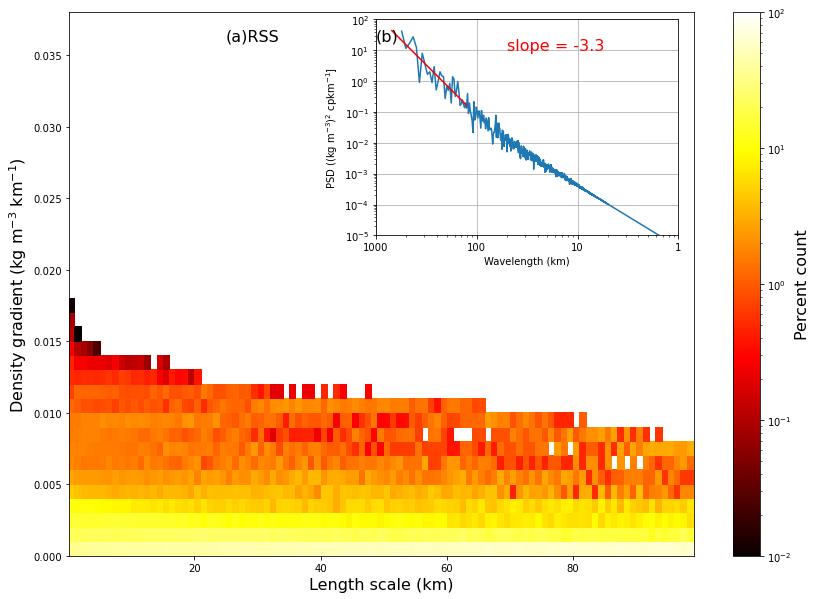

In [407]:
#psd_fig(freq_usv,ddn_usv,Pxx_den_usv,'Saildrone','PSD_den_grad_usv.png',300)
psd_fig(freq_jpl,ddn_jpl,Pxx_den_jpl,'JPL','PSD_den_grad_jpl.png',45)
psd_fig(freq_rss,ddn_rss,Pxx_den_rss,'RSS','PSD_den_grad_rss_.png',45)
#psd_fig(freq_rss4,ddn_rss4,Pxx_den_rss4,'RSS 40km','PSD_den_grad_rss_40km.png',75)


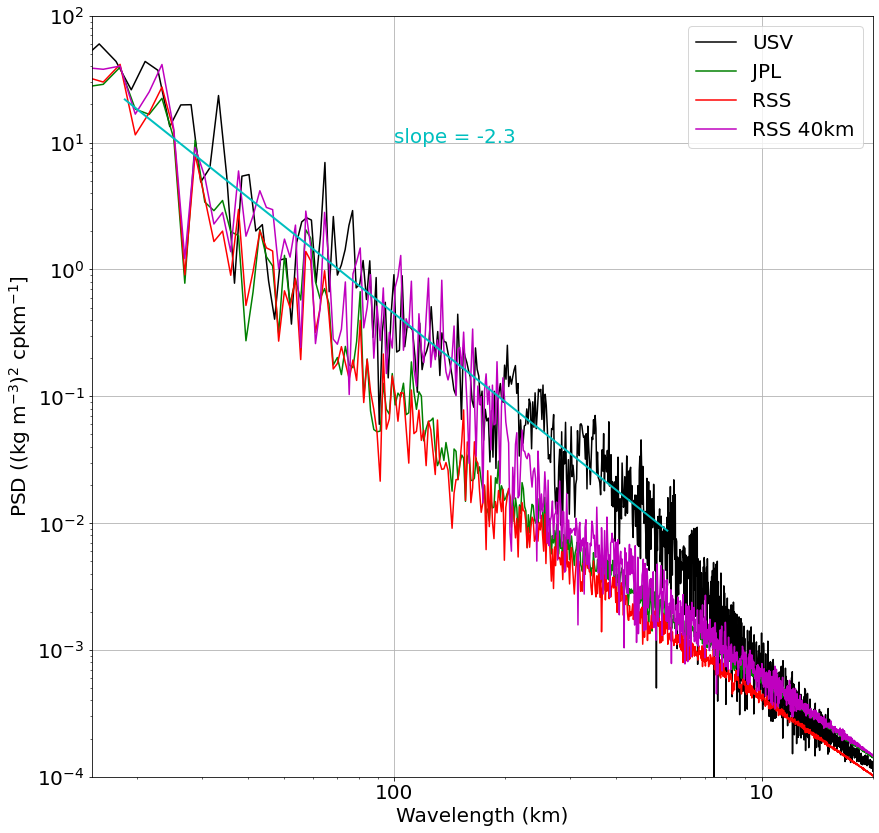

In [399]:
#cal PSD
fig = plt.figure(figsize=(14,14))
#Pxx_den = np.mean(ps_all_usv,axis=0)
#f, Pxx_den = signal.periodogram(Pxx_den,1/.080)  #fs = sampled at .08km or 80m
istart,iend=5,5550
plt.loglog(freq_usv[istart:iend], Pxx_den_usv[istart:iend],'k',label='USV')
plt.loglog(freq_jpl[istart:iend], Pxx_den_jpl[istart:iend],'g',label='JPL')
plt.loglog(freq_rss[istart:iend], Pxx_den_rss[istart:iend],'r',label='RSS')
plt.loglog(freq_rss4[istart:iend], Pxx_den_rss4[istart:iend],'m',label='RSS 40km')

#linear regression to PSD
Pxx_den = np.mean(ps_all_usv,axis=0)
istart,iend=10,300
XX,YY = np.log(freq_usv[istart:iend]),np.log(Pxx_den[istart:iend])
reg = LinearRegression().fit(XX.reshape(-1, 1), YY)
a,b = float(reg.coef_), -1*float(reg.intercept_)
plt.loglog(f[istart:iend], f[istart:iend]**(a)/np.exp(b),'c',linewidth=2) #test from fit
slp_str = 'slope = '+"{:.1f}".format(a)
plt.text(.01,10,slp_str,fontsize=20,color='c')

plt.ylim([10e-5,10e1])
plt.xlim([.0015,.2])
plt.legend(fontsize=20)

#plt.text(.001,20,'(b)',fontsize=16,color='k')
plt.xlabel('Wavelength (km)',fontsize=20)
#plt.xlabel('Wavenumber (cpkm)',fontsize=20)
plt.ylabel('PSD ((kg m$^{-3}$)$^2$ cpkm$^{-1}$]',fontsize=20)
plt.xticks(ticks=[.01,.1],labels=['100','10'],fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.savefig(figs_dir+'all_spectrusm_only.png')


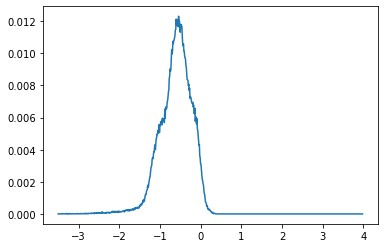

In [94]:
hist air sea temp diff
for iusv in range(3):
    ds_usv = ds.isel(trajectory=iusv)
    dif = ds_usv.TEMP_AIR_MEAN-ds_usv.TEMP_SBE37_MEAN
    hist, bin_edges = np.histogram(dif,bins=np.arange(-3.5,4,0.01))
    if iusv==0:
        hist2 = hist
    else:
        hist2+=hist
hist2=hist2/sum(hist2)
plt.plot(bin_edges[:-1],hist2)

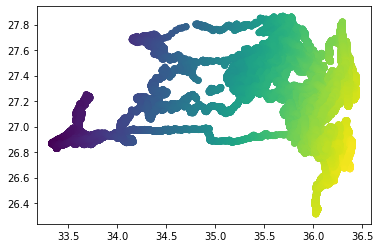

In [96]:
for iusv in range(3):
    plt.scatter(ds_usv.SAL_SBE37_MEAN,ds_usv.TEMP_SBE37_MEAN,c=ds_usv.density_mean)


3567.339265632886 4274.542512546288
['3750', '3850', '3950', '4050', '4150', '4250', '4350']
3567.339265632886 4274.542512546288
[0.028638439698802618, 0.12418219972842859, 0.24416738674237748, 0.43895815331440563, 0.6268361930625849, 0.7585483273669917, 0.9003826688063202]


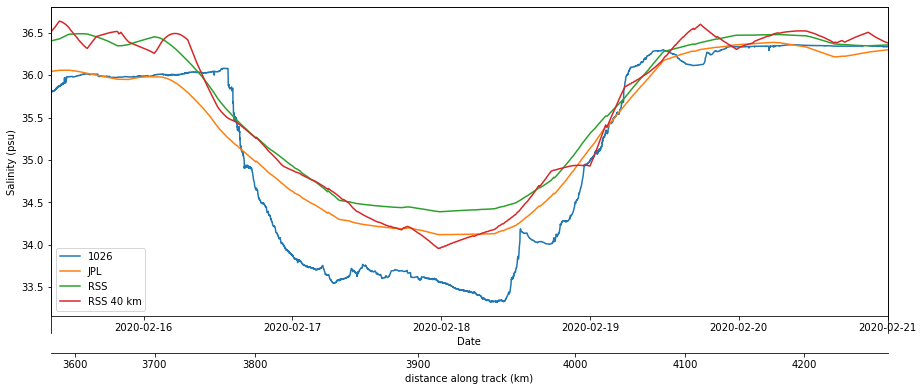

In [181]:
def ts_plot(t1,t2,var1,var2,var3,var4,ystr,figs_dir,ds_in,ds_rss_in,ds_jpl_in,str2,offset):
    import math
    iusv=0
    ds_usv = ds_in.isel(trajectory=iusv).sel(time=slice(t1,t2))
    print(ds_usv.dist_total[0].data,ds_usv.dist_total[-1].data)
    ll=[]
    for i in range(3750,4450,100):
        ll.append("{:.0f}".format(i))
    print(ll)
    fig,(ax0)= plt.subplots(1,1,figsize=(15,6))
    for iusv in range(1):
        ds_usv = ds.isel(trajectory=iusv).sel(time=slice(t1,t2))
        ax0.plot(ds_usv.time,ds_usv[var1],label=ds_usv.trajectory.data)
    ds_usv = ds_jpl_in.isel(trajectory=0).sel(time=slice(t1,t2))
    ax0.plot(ds_usv.time,ds_usv[var2]+offset,label='JPL')
    ds_usv = ds_rss_in.isel(trajectory=0).sel(time=slice(t1,t2))
    ax0.plot(ds_usv.time,ds_usv[var3]+offset,label='RSS')
    ax0.plot(ds_usv.time,ds_usv[var4]+offset,label='RSS 40 km')
    ax0.legend()
    ax0.set_ylabel(ystr)
    ax0.set_xlabel('Date')
#    ax0.set_xlim([np.datetime64(t1),np.datetime64(t2)])
    ax0.set_xlim([t1,t2])

    pos = ax0.get_position()
    pos.y0 = pos.y0+.04       # for example 0.2, choose your value
    ax0.set_position(pos)
    ax2 = ax0.twiny()
    # Move twinned axis ticks and label from top to bottom
    ax2.xaxis.set_ticks_position("bottom")
    ax2.xaxis.set_label_position("bottom")
    # Offset the twin axis below the host
    ax2.spines["bottom"].set_position(("axes", -0.06))
    ax1Ticks = ax0.get_xticks()   
    ax2Ticks = ax1Ticks
    
    #calculate new ticks
    temdist = ds_usv.dist_total.data
    print(ds_usv.dist_total[0].data,ds_usv.dist_total[-1].data)
    tem = np.arange(math.ceil(ds_usv.dist_total[0].data/50)*50,math.floor(ds_usv.dist_total[-1].data/50)*50+60,100)
    ll=[]
    for i in tem: #range(3750,4450,100):
        ll.append("{:.0f}".format(i))
    isv=[]
    for i in tem:
        ii = np.argwhere((ds_usv.dist_total.data.astype(int))==i)
        if len(ii)>0:
            isv.append(int(ii.mean())/len(temdist))   
    
    new_tick_locations = isv
    print(new_tick_locations)
    ax2.set_xticks(new_tick_locations)
    ax2.set_xticklabels(ll)
    ax2.set_xlabel('distance along track (km)')
    plt.savefig(figs_dir+ 'timeseries_'+str(t1)+'eddy'+str2+'.png')

t1,t2 = np.datetime64('2020-02-15T09'),np.datetime64('2020-02-21T00')
offset=0
var1,var2,var3,var4,ystr= 'SAL_SBE37_MEAN','smap_sss','sss_smap','sss_smap_40km','Salinity (psu)'
ts_plot(t1,t2,var1,var2,var3,var4,ystr,figs_dir,ds,ds_rss_usv,ds_jpl_usv,'salinity',offset)

0.10946612830351345 416.1294537349377
['3750', '3850', '3950', '4050', '4150', '4250', '4350']
0.10946612830351345 416.1294537349377
[0.10529969914371673, 0.36449895857440406, 0.5651469567229808, 0.7921777366350382]
416.1294537349377 835.8946319832381
['3750', '3850', '3950', '4050', '4150', '4250', '4350']
416.1294537349377 835.8946319832381
[0.0541591445632551, 0.2248298847382308, 0.4373003749479239, 0.8100263852242744]
835.8946319832381 1407.1370470680831
['3750', '3850', '3950', '4050', '4150', '4250', '4350']
835.8946319832381 1407.1370470680831
[0.02263574503541175, 0.15497847521177613, 0.28315511734481325, 0.4559089015414526, 0.6585196500486044, 0.865018747396195]
1407.1370470680831 2014.9501635499403
['3750', '3850', '3950', '4050', '4150', '4250', '4350']
1407.1370470680831 2014.9501635499403
[0.08234967365643661, 0.2691292875989446, 0.40522149701430354, 0.5290931815025691, 0.6847660047215665, 0.8791834467435079]
2014.9501635499403 2688.4088886176764
['3750', '3850', '3950', '

IndexError: index 0 is out of bounds for axis 0 with size 0

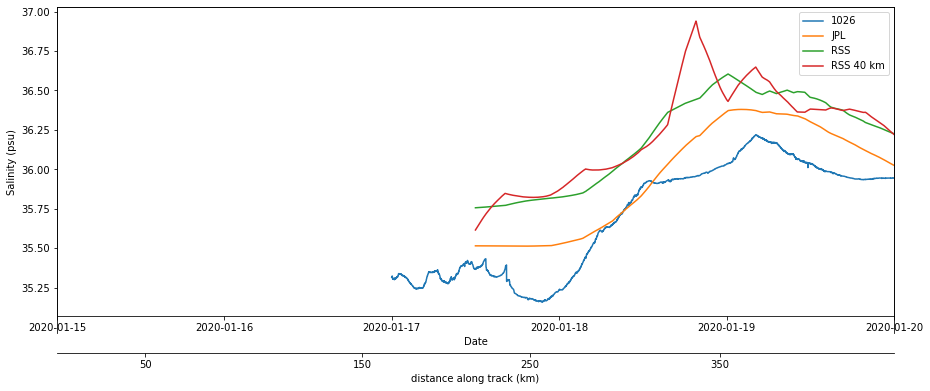

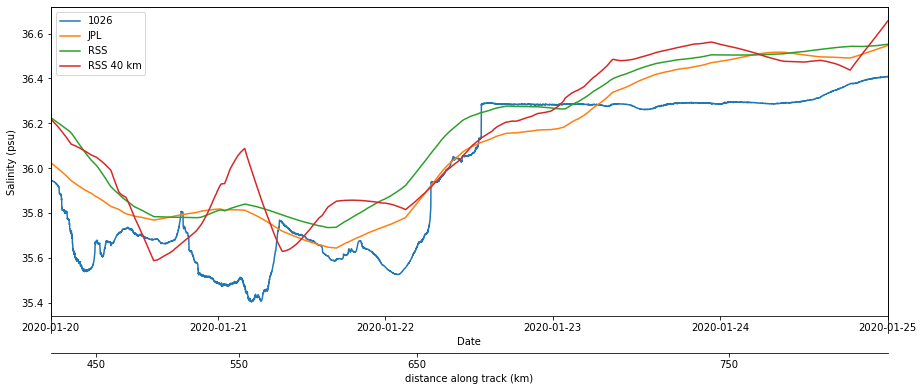

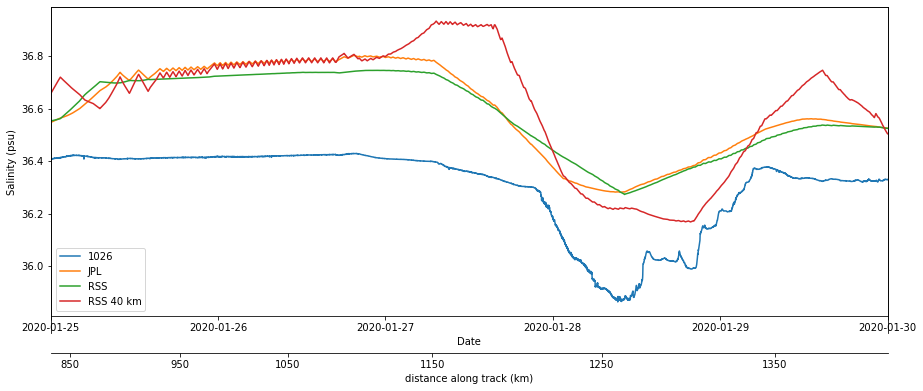

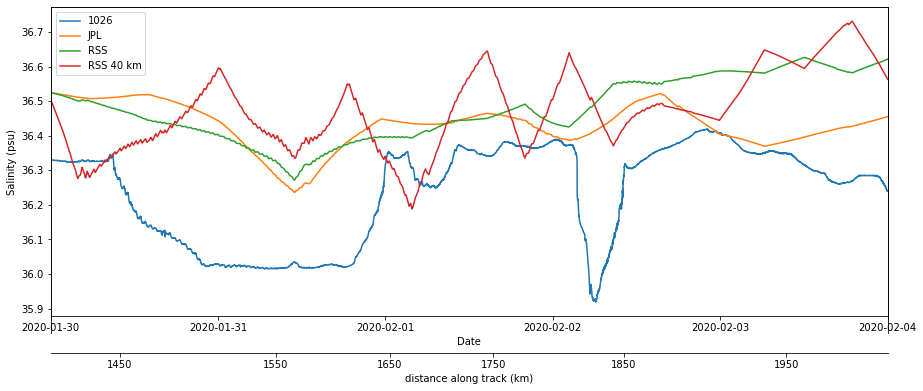

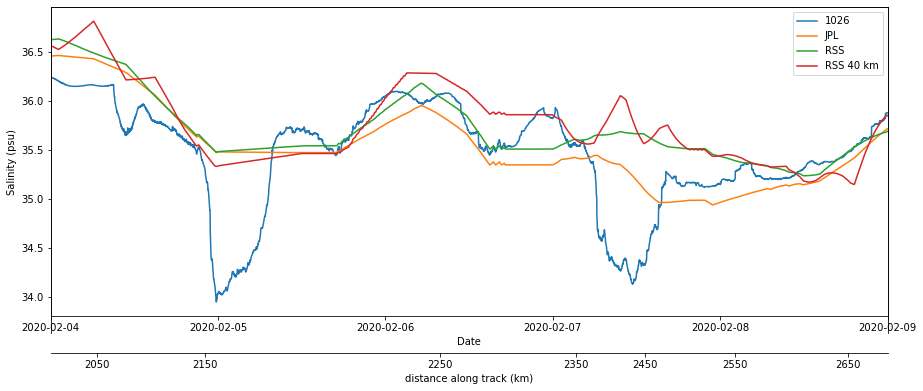

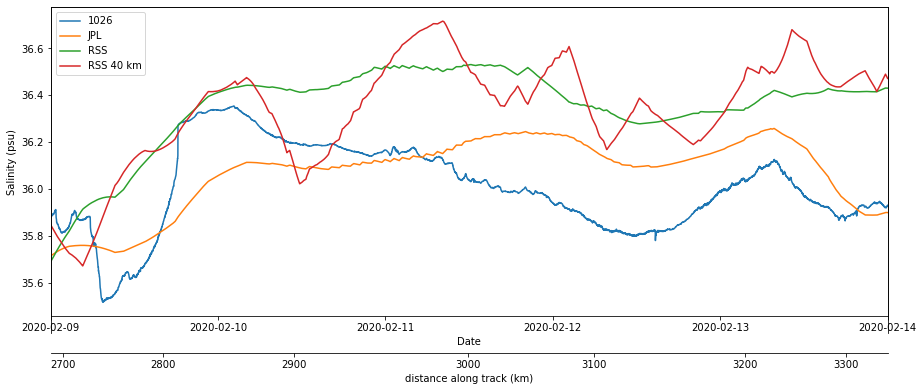

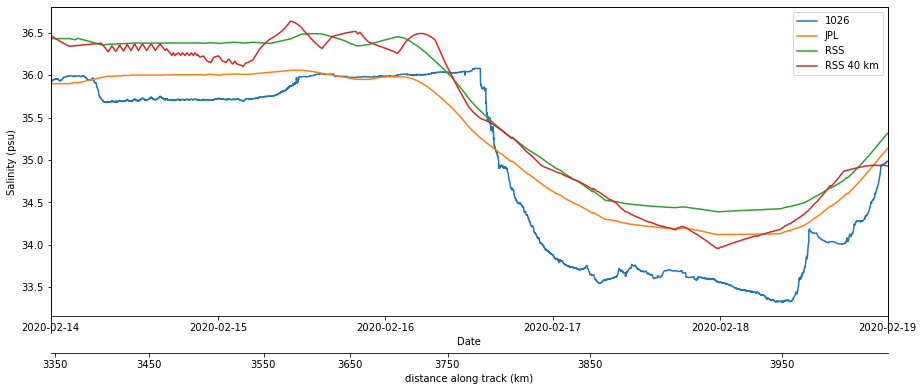

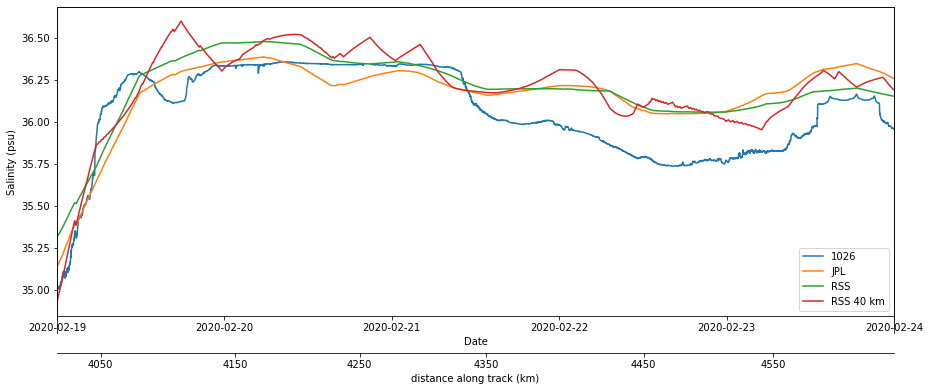

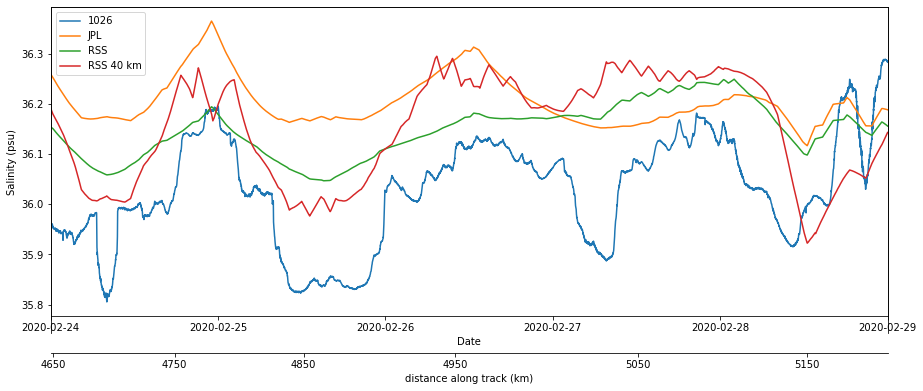

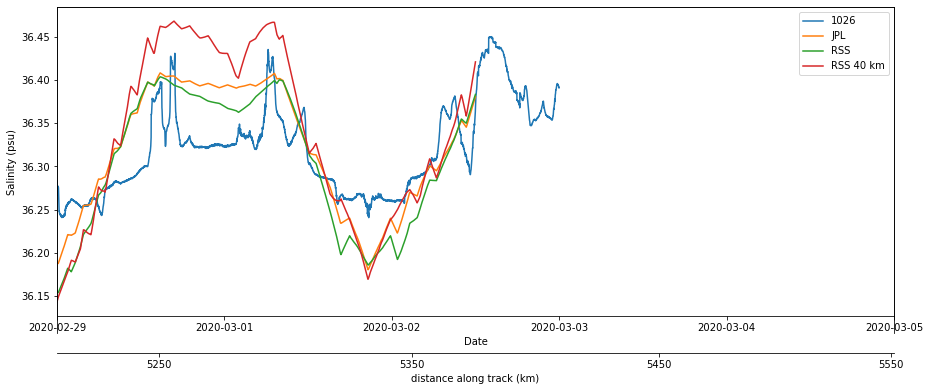

In [182]:
t1,t2 = np.datetime64('2020-02-15T09'),np.datetime64('2020-02-21T00')
var1,var2,var3,var4,ystr= 'SAL_SBE37_MEAN','smap_sss','sss_smap','sss_smap_40km','Salinity (psu)'
dy1 = ds.time[0]
offset=0
for i in range(12):
    t1 = np.datetime64('2020-01-20')+np.timedelta64((i-1)*5,'D')
    t2 = t1+np.timedelta64(5,'D')
    ts_plot(t1,t2,var1,var2,var3,var4,ystr,figs_dir,ds,ds_rss_usv,ds_jpl_usv,'salinity',offset)

0.10946612830351345 416.1294537349377
['3750', '3850', '3950', '4050', '4150', '4250', '4350']
0.10946612830351345 416.1294537349377
[0.10529969914371673, 0.36449895857440406, 0.5651469567229808, 0.7921777366350382]
416.1294537349377 835.8946319832381
['3750', '3850', '3950', '4050', '4150', '4250', '4350']
416.1294537349377 835.8946319832381
[0.0541591445632551, 0.2248298847382308, 0.4373003749479239, 0.8100263852242744]
835.8946319832381 1407.1370470680831
['3750', '3850', '3950', '4050', '4150', '4250', '4350']
835.8946319832381 1407.1370470680831
[0.02263574503541175, 0.15497847521177613, 0.28315511734481325, 0.4559089015414526, 0.6585196500486044, 0.865018747396195]
1407.1370470680831 2014.9501635499403
['3750', '3850', '3950', '4050', '4150', '4250', '4350']
1407.1370470680831 2014.9501635499403
[0.08234967365643661, 0.2691292875989446, 0.40522149701430354, 0.5290931815025691, 0.6847660047215665, 0.8791834467435079]
2014.9501635499403 2688.4088886176764
['3750', '3850', '3950', '

IndexError: index 0 is out of bounds for axis 0 with size 0

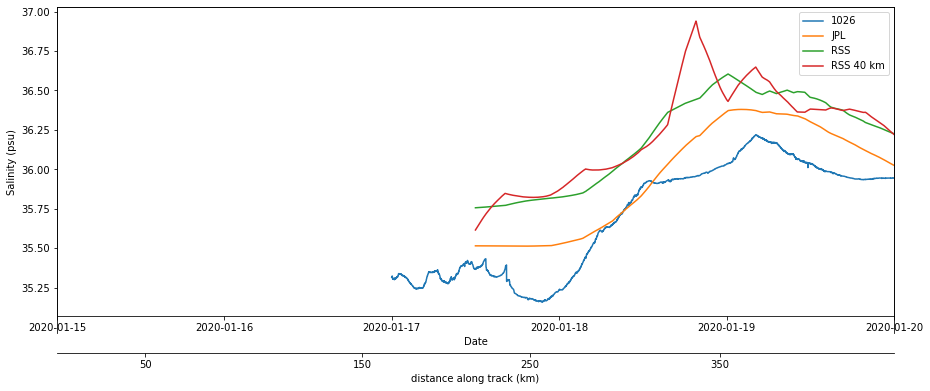

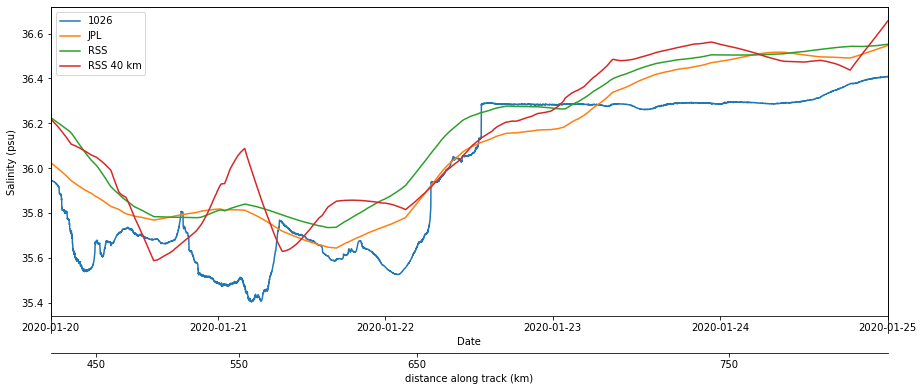

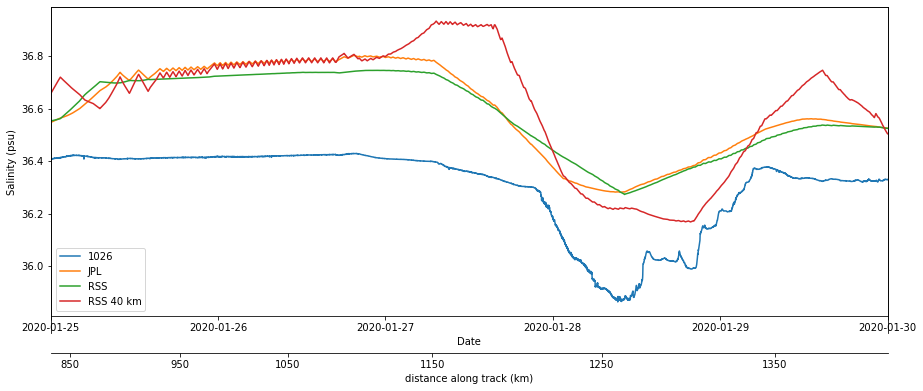

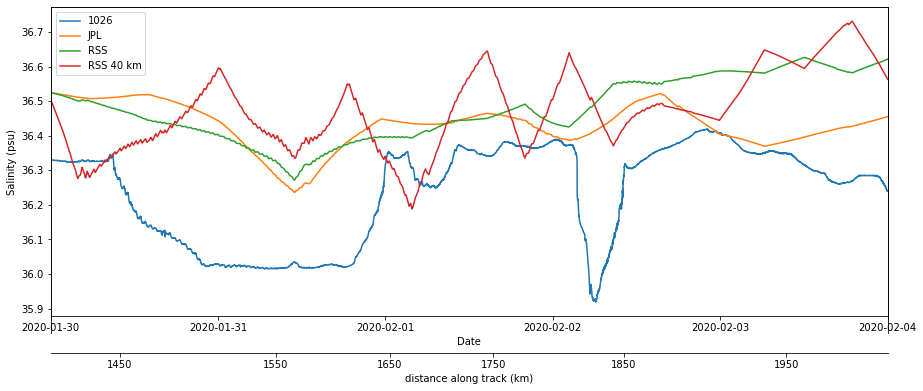

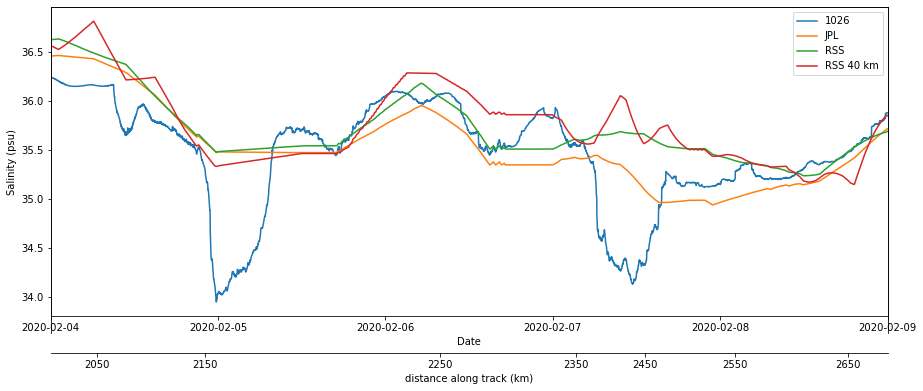

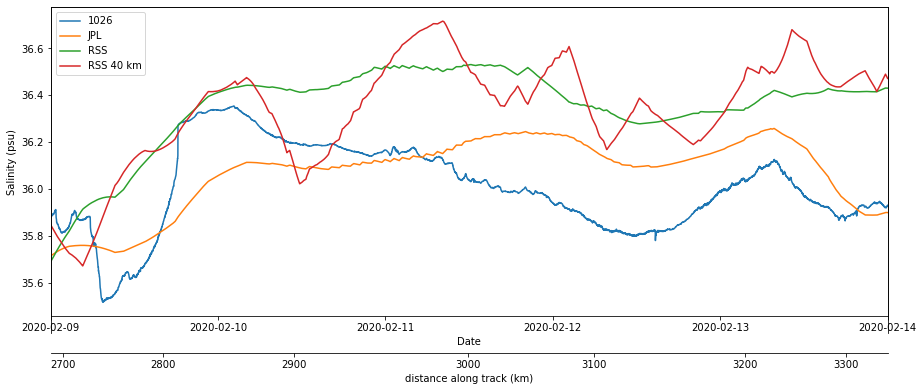

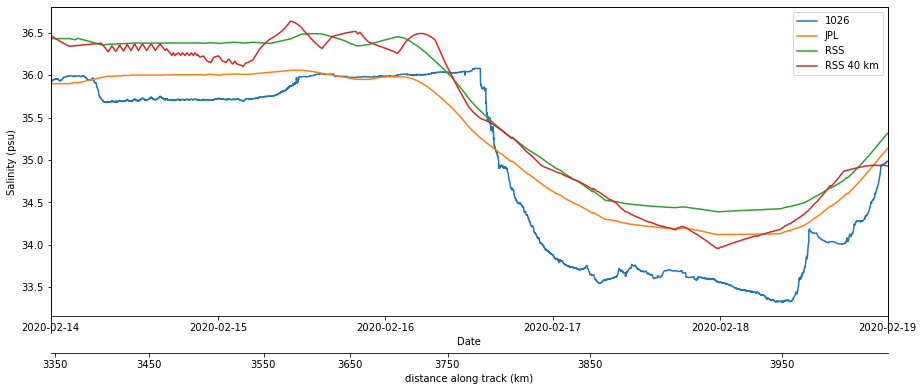

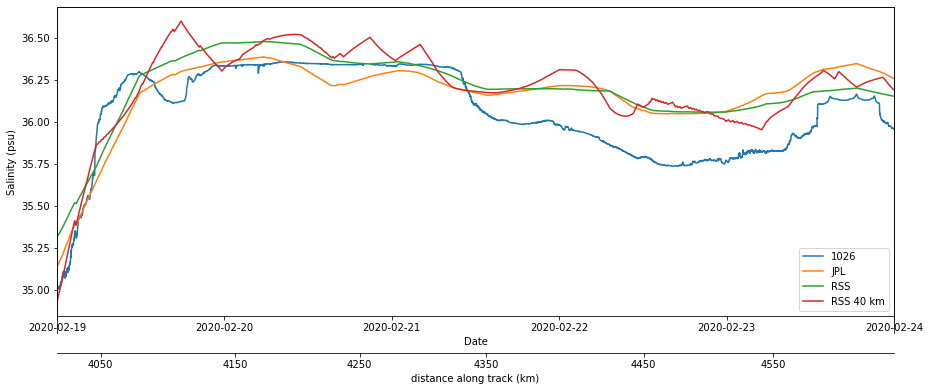

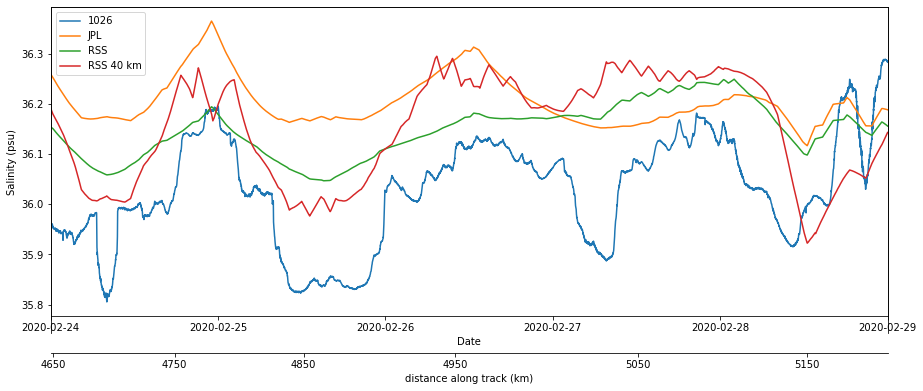

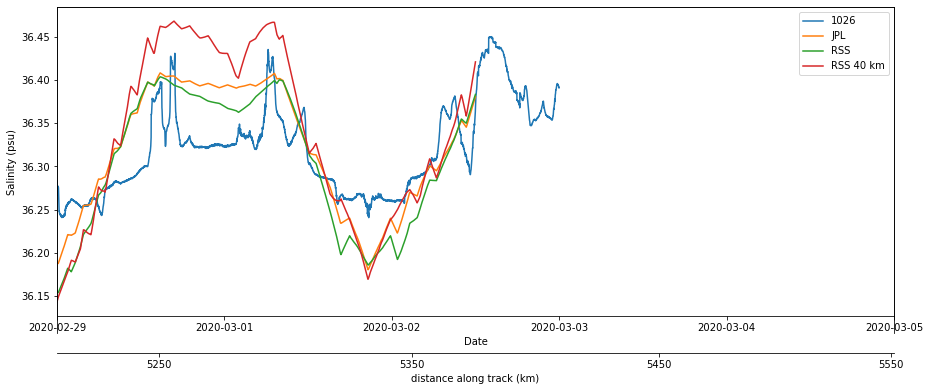

In [183]:
t1,t2 = np.datetime64('2020-02-15T09'),np.datetime64('2020-02-21T00')
var1,var2,var3,var4,ystr= 'SAL_SBE37_MEAN','smap_sss','sss_smap','sss_smap_40km','Salinity (psu)'
dy1 = ds.time[0]
offset=0
for i in range(12):
    t1 = np.datetime64('2020-01-20')+np.timedelta64((i-1)*5,'D')
    t2 = t1+np.timedelta64(5,'D')
    ts_plot(t1,t2,var1,var2,var3,var4,ystr,figs_dir,ds,ds_rss_usv,ds_jpl_usv,'salinity',offset)

0.10946612830351345 416.1294537349377
['3750', '3850', '3950', '4050', '4150', '4250', '4350']
0.10946612830351345 416.1294537349377
[0.10529969914371673, 0.36449895857440406, 0.5651469567229808, 0.7921777366350382]
416.1294537349377 835.8946319832381
['3750', '3850', '3950', '4050', '4150', '4250', '4350']
416.1294537349377 835.8946319832381
[0.0541591445632551, 0.2248298847382308, 0.4373003749479239, 0.8100263852242744]
835.8946319832381 1407.1370470680831
['3750', '3850', '3950', '4050', '4150', '4250', '4350']
835.8946319832381 1407.1370470680831
[0.02263574503541175, 0.15497847521177613, 0.28315511734481325, 0.4559089015414526, 0.6585196500486044, 0.865018747396195]
1407.1370470680831 2014.9501635499403
['3750', '3850', '3950', '4050', '4150', '4250', '4350']
1407.1370470680831 2014.9501635499403
[0.08234967365643661, 0.2691292875989446, 0.40522149701430354, 0.5290931815025691, 0.6847660047215665, 0.8791834467435079]
2014.9501635499403 2688.4088886176764
['3750', '3850', '3950', '

IndexError: index 0 is out of bounds for axis 0 with size 0

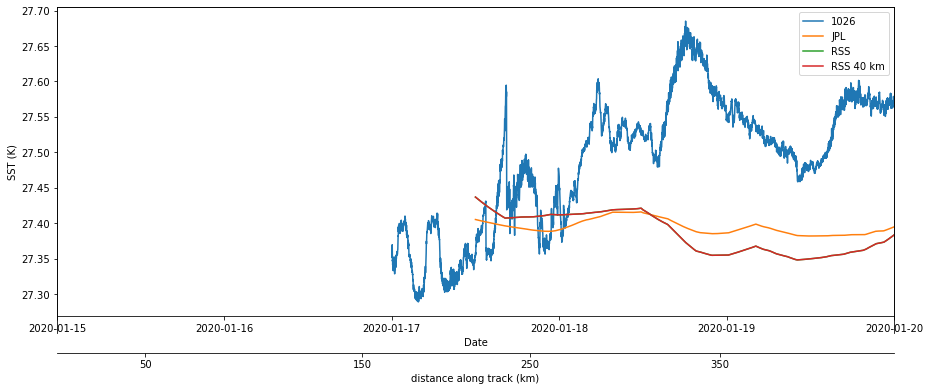

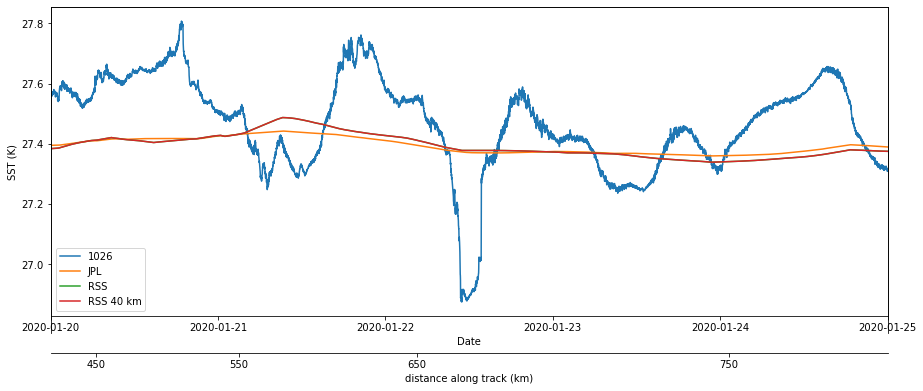

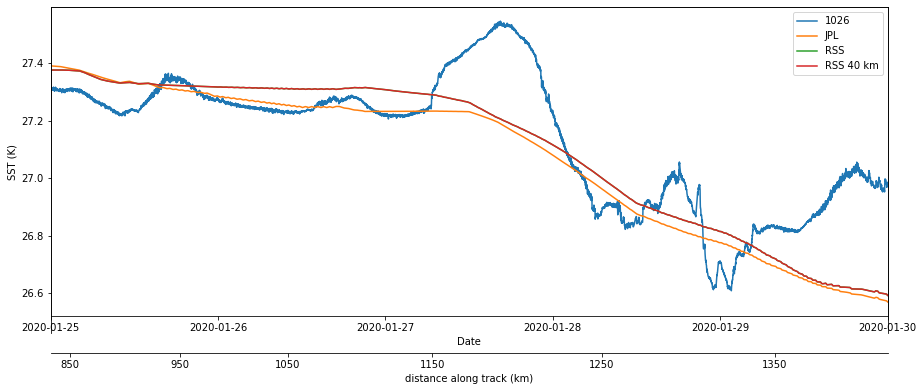

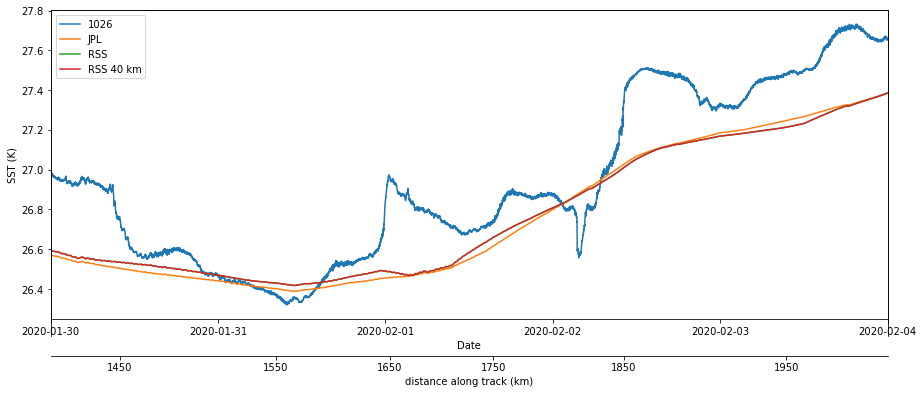

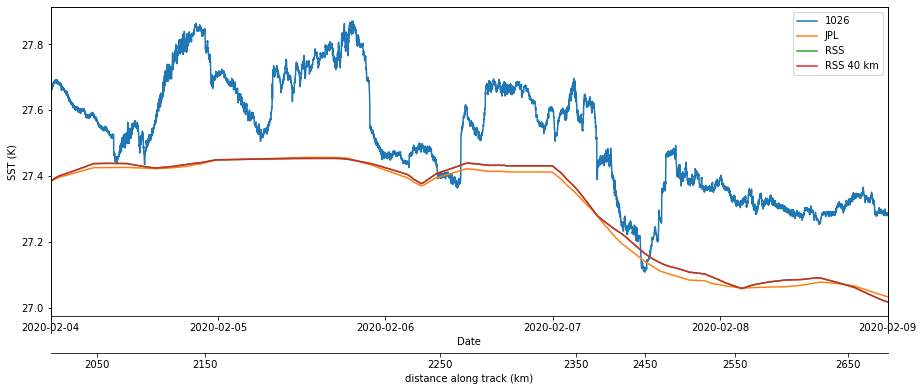

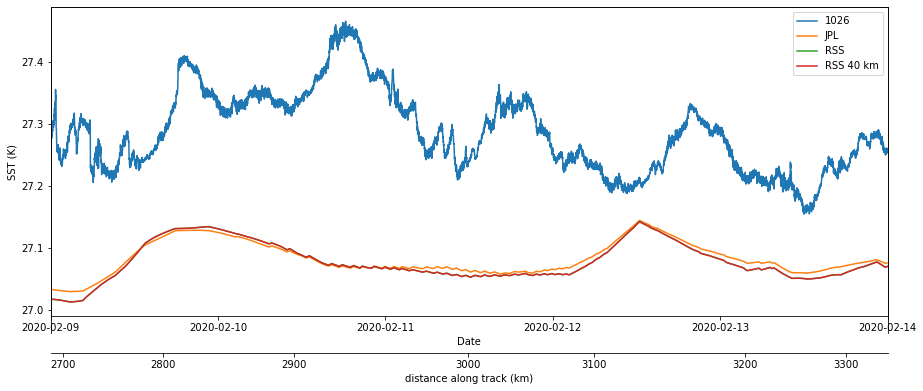

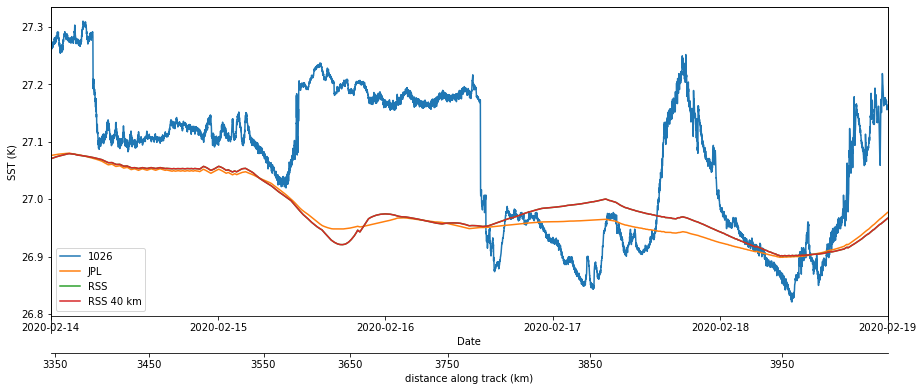

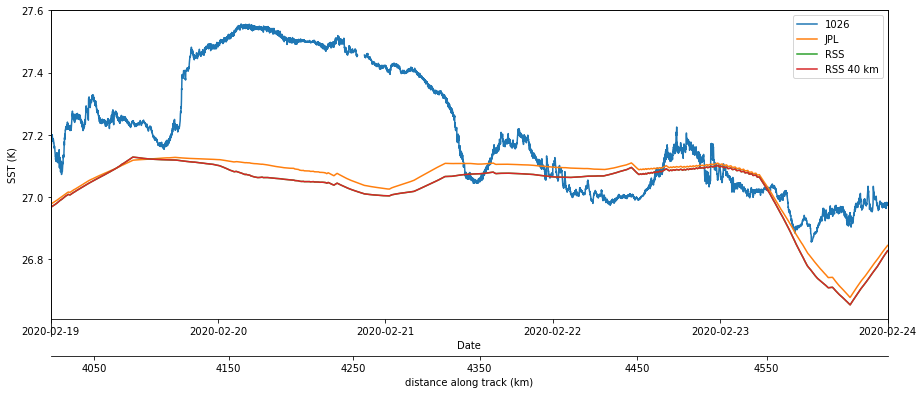

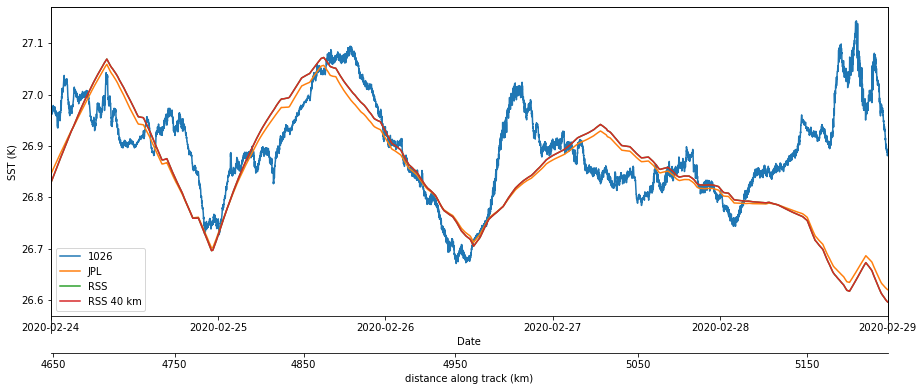

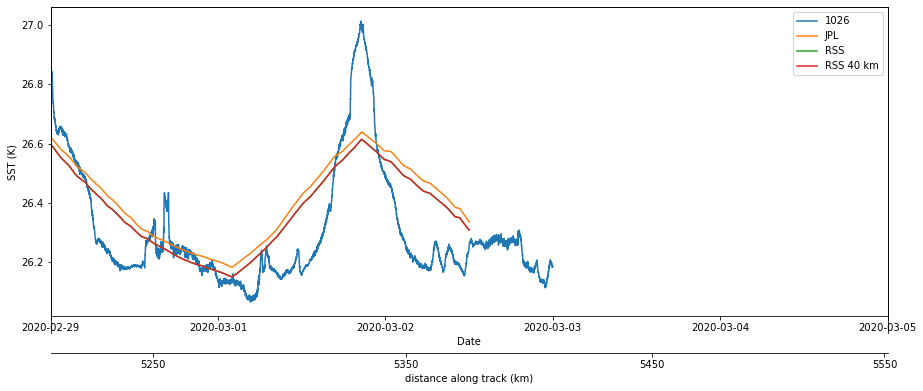

In [184]:
t1,t2 = np.datetime64('2020-02-15T09'),np.datetime64('2020-02-21T00')
var1,var2,var3,var4,ystr= 'TEMP_SBE37_MEAN','anc_sst','surtep','surtep','SST (K)'
dy1 = ds.time[0]
offset=-273.15
for i in range(12):
    t1 = np.datetime64('2020-01-20')+np.timedelta64((i-1)*5,'D')
    t2 = t1+np.timedelta64(5,'D')
    ts_plot(t1,t2,var1,var2,var3,var4,ystr,figs_dir,ds,ds_rss_usv,ds_jpl_usv,'sst',offset)

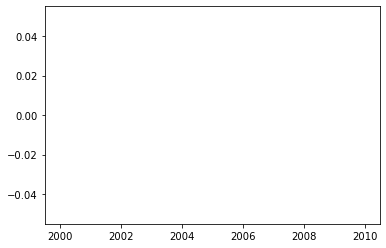

In [213]:
for i in range(1):
    t1 = np.datetime64('2020-01-20')+np.timedelta64((i-1)*5,'D')
    t2 = t1+np.timedelta64(5,'D')
    tem = ds_log.isel(trajectory=0)
    tem = tem.swap_dims({'obs':'time'}).sel(time=slice(t1,t2))
    plt.plot(tem.time,tem.sea_water_temperature_00_mean-tem.sea_water_temperature_03_mean)
    plt.plot(tem.time,tem.sea_water_temperature_01_mean-tem.sea_water_temperature_03_mean)
    plt.plot(tem.time,tem.sea_water_temperature_02_mean-tem.sea_water_temperature_03_mean)
        

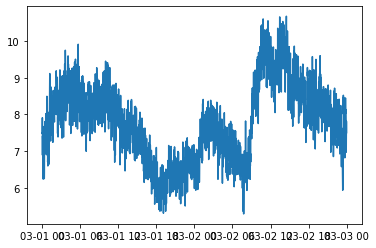

In [229]:
    tem = ds_log.isel(trajectory=0)
    tem2 = ds.isel(trajectory=0).sel(time=slice('2020-03-01','2020-03-10'))
    tem = tem.swap_dims({'obs':'time'})
#    plt.plot(tem.time,tem.sea_water_temperature_00_mean-tem.sea_water_temperature_03_mean)
#    plt.plot(ds.time,tem2.TEMP_SBE37_MEAN-tem.sea_water_temperature_03_mean)
#    plt.plot(ds.time,tem2.TEMP_SBE37_MEAN)
    plt.plot(tem2.time,tem2.wspd)
#    plt.plot(tem.time,tem.sea_water_temperature_01_mean-tem.sea_water_temperature_03_mean)
#    plt.plot(tem.time,tem.sea_water_temperature_02_mean-tem.sea_water_temperature_03_mean)


In [220]:
tem2

<xarray.Dataset>
Dimensions:                         (time: 66240)
Coordinates:
  * time                            (time) datetime64[ns] 2020-01-17 ... 2020-03-02T23:59:00
    latitude                        (time) float64 11.77 11.77 ... 9.47 9.469
    longitude                       (time) float64 -56.28 -56.28 ... -51.29
    trajectory                      <U4 '1026'
Data variables:
    SOG                             (time) float64 2.214 1.88 ... 2.315 2.153
    SOG_FILTERED_MEAN               (time) float64 1.894 1.908 ... 1.896 1.838
    SOG_FILTERED_STDDEV             (time) float64 0.251 0.271 ... 0.37 0.327
    SOG_FILTERED_MAX                (time) float64 2.597 2.822 ... 2.53 2.408
    SOG_FILTERED_MIN                (time) float64 1.465 1.186 ... 1.027 1.133
    COG                             (time) float64 153.7 165.1 ... 227.9 216.7
    COG_FILTERED_MEAN               (time) float64 160.0 159.5 ... 219.7 219.0
    COG_FILTERED_STDDEV             (time) float64 12.3 12.5 14.5 ... 10.6 11.0
    HDG                             (time) float64 152.0 151.7 ... 211.8 208.1
    HDG_FILTERED_MEAN               (time) float64 148.3 152.1 ... 212.2 208.8
    HDG_FILTERED_STDDEV             (time) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ROLL_FILTERED_MEAN              (time) float64 11.9 -2.8 1.0 ... 2.8 0.5 0.3
    ROLL_FILTERED_STDDEV            (time) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ROLL_FILTERED_PEAK              (time) float64 11.9 -2.8 1.0 ... 2.8 0.5 0.3
    PITCH_FILTERED_MEAN             (time) float64 9.3 -1.0 2.1 ... -4.9 3.4 2.6
    PITCH_FILTERED_STDDEV           (time) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    PITCH_FILTERED_PEAK             (time) float64 9.3 -1.0 2.1 ... -4.9 3.4 2.6
    HDG_WING                        (time) float64 103.3 91.6 ... 107.7 108.1
    WING_HDG_FILTERED_MEAN          (time) float64 99.6 98.6 ... 108.6 107.9
    WING_HDG_FILTERED_STDDEV        (time) float64 3.8 4.7 3.9 ... 5.0 4.1 2.7
    WING_ROLL_FILTERED_MEAN         (time) float64 3.3 3.6 2.4 ... 0.8 0.8 0.8
    WING_ROLL_FILTERED_STDDEV       (time) float64 3.4 4.8 4.3 ... 3.4 3.1 3.5
    WING_ROLL_FILTERED_PEAK         (time) float64 nan nan nan ... nan nan nan
    WING_PITCH_FILTERED_MEAN        (time) float64 3.7 3.7 2.9 ... 0.3 0.1 -0.2
    WING_PITCH_FILTERED_STDDEV      (time) float64 5.3 4.4 5.9 ... 6.8 5.2 5.9
    WING_PITCH_FILTERED_PEAK        (time) float64 15.8 12.4 15.2 ... 12.5 -17.6
    WING_ANGLE                      (time) float64 -48.8 -60.2 ... -103.6 -99.8
    UWND_MEAN                       (time) float64 -8.51 -7.56 ... -7.77 -7.45
    UWND_STDDEV                     (time) float64 0.61 0.6 0.73 ... 0.49 0.53
    VWND_MEAN                       (time) float64 -1.83 -2.5 ... -0.82 -0.89
    VWND_STDDEV                     (time) float64 0.59 0.59 0.54 ... 0.38 0.32
    WWND_MEAN                       (time) float64 -0.1 -0.03 ... -0.06 -0.07
    WWND_STDDEV                     (time) float64 0.32 0.43 0.41 ... 0.31 0.27
    GUST_WND_MEAN                   (time) float64 9.7 8.82 8.48 ... 8.37 8.43
    GUST_WND_STDDEV                 (time) float64 0.5 0.48 0.61 ... 0.37 0.42
    WIND_MEASUREMENT_HEIGHT_MEAN    (time) float64 4.947 4.949 ... 4.966 4.972
    WIND_MEASUREMENT_HEIGHT_STDDEV  (time) float64 0.059 0.055 ... 0.038 0.034
    TEMP_AIR_MEAN                   (time) float64 26.98 26.98 ... 25.95 25.94
    TEMP_AIR_STDDEV                 (time) float64 0.03 0.03 0.03 ... 0.02 0.02
    RH_MEAN                         (time) float64 79.77 80.07 ... 79.72 79.76
    RH_STDDEV                       (time) float64 0.49 0.38 0.54 ... 0.26 0.21
    BARO_PRES_MEAN                  (time) float64 1.016e+03 ... 1.015e+03
    BARO_PRES_STDDEV                (time) float64 0.06 0.08 0.11 ... 0.06 0.06
    PAR_AIR_MEAN                    (time) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    PAR_AIR_STDDEV                  (time) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    TEMP_IR_SEA_WING_UNCOMP_MEAN    (time) float6

# Check what the min/max/mean distance travelled between 1 min obs

In [ ]:
for iusv in range(3):
    print(ds.dist_between[iusv,:].min().data,ds.dist_between[iusv,:].max().data,ds.dist_between[iusv,:].mean().data)
#ave distance is 0.08 km = 80 m 

# Make an evenly sampled timeseries
- Swap the coordinates from time to distance_total
- interp along evenly sampled distance total, 80m (0.08km)

In [ ]:
ds_usv = ds.isel(trajectory=0)
ds2 = ds_usv.assign_coords(dist_total = ds_usv.dist_total)
ds3 = ds2.swap_dims({'time':'dist_total'})
dist_interp = np.arange(ds2.dist_total[0],ds2.dist_total[-1],0.08)
ds4 = ds3.interp(dist_total=dist_interp)

In [ ]:
plt.plot(ds2.time,ds3.density_mean)
plt.plot(ds_usv.time,ds_usv.density_mean)


# detrend

In [ ]:
den = ds4.density_mean.interpolate_na(dim='dist_total')
ds4_detrend = signal.detrend(den)

In [ ]:
#plt.plot(ds4.density_mean)
#plt.plot(den)
plt.plot(ds4_detrend)

# , smooth using 2km gaussian filter then power density

In [ ]:
ds4_detrend_smooth = scipy.ndimage.filters.gaussian_filter1d(ds4_detrend, sigma=25)
plt.plot(ds4_detrend_smooth[5000:7000])
plt.plot(ds4_detrend[5000:7000])


In [ ]:
f, Pxx_den = signal.periodogram(ds4_detrend_smooth,1/.080)  #fs = sampled at .08km or 80m
plt.loglog(f[2:5000], Pxx_den[2:5000])
plt.loglog(f[2:5000], f[2:5000]**(-2.4)/100000)
#plt.semilogy(f[2:200], Pxx_den[2:200])
plt.xlabel('frequency [km]')
plt.ylabel('PSD [kg/m^3 /km]')

# okay, now do all the USV

In [ ]:
data_all=[]
for iusv in range(3):
    ds_usv = ds.isel(trajectory=0)
    ds2 = ds_usv.assign_coords(dist_total = ds_usv.dist_total)
    ds3 = ds2.swap_dims({'time':'dist_total'})
    dist_interp = np.arange(ds2.dist_total[0],ds2.dist_total[-1],0.08)
    ds4 = ds3.interp(dist_total=dist_interp)
    den = ds4.density_mean.interpolate_na(dim='dist_total')
    ds4_detrend = signal.detrend(den)
    ds4_detrend_smooth = scipy.ndimage.filters.gaussian_filter1d(ds4_detrend, sigma=25)
    f, Pxx_den = signal.periodogram(ds4_detrend_smooth,1/.080)  #fs = sampled at .08km or 80m
    if iusv==0:
        data_all=ds4_detrend_smooth
        ps_all=Pxx_den[0:10000]
    else:
        data_all = np.concatenate([data_all,ds4_detrend_smooth])
        ps_all = np.vstack([ps_all,Pxx_den[0:10000]])
    print(iusv)
f, Pxx_den = signal.periodogram(data_all[:101000],1/.080)  #fs = sampled at .08km or 80m
plt.loglog(f[5:900], Pxx_den[5:900])
plt.loglog(f[5:900], f[5:900]**(-2.4)/100000)
plt.xlabel('frequency [km]')
plt.ylabel('PSD [kg/m^3 /km]')

In [ ]:
Pxx_den = np.mean(ps_all,axis=0)
#f, Pxx_den = signal.periodogram(data_all[:101000],1/.080)  #fs = sampled at .08km or 80m
plt.loglog(f[5:900], Pxx_den[5:900])
plt.loglog(f[5:900], f[5:900]**(-2.4)/100000)
plt.xlabel('frequency [km]')
plt.ylabel('PSD [kg/m^3 /km]')

In [ ]:
for iusv in range(3):
    len2=0.1
    ds_usv = ds.isel(trajectory=iusv)
    ds2 = ds_usv.assign_coords(dist_total = ds_usv.dist_total)  #add dist traveled coordinate
    ds3 = ds2.swap_dims({'time':'dist_total'})                  #swap from time to distance traveled
    dist_interp = np.arange(ds2.dist_total[0],ds2.dist_total[-1],len2)
    ds4 = ds3.interp(dist_total=dist_interp)       
    den_grad =  np.abs(np.gradient(ds4.density_mean)/len2)
    print(np.nanmax(den_grad))
    print('dist:',dist_interp.max())

In [ ]:
for iusv in range(3):
    len2=0.1
    ds_usv = ds.isel(trajectory=iusv)
    ds2 = ds_usv.assign_coords(dist_total = ds_usv.dist_total)  #add dist traveled coordinate
    ds3 = ds2.swap_dims({'time':'dist_total'})                  #swap from time to distance traveled
    dist_interp = np.arange(ds2.dist_total[0],ds2.dist_total[-1],len2)
    ds4 = ds3.interp(dist_total=dist_interp)       
    den_grad =  np.abs(np.gradient(ds4.density_mean)/len2)
    print(np.nanmax(den_grad))
    print('dist:',dist_interp.max())
    plt.plot(den_grad)

In [ ]:
for iusv in range(3):
    len2=0.1
    ds_usv = ds.isel(trajectory=iusv)
    ds2 = ds_usv.assign_coords(dist_total = ds_usv.dist_total)  #add dist traveled coordinate
    ds3 = ds2.swap_dims({'time':'dist_total'})                  #swap from time to distance traveled
    dist_interp = np.arange(ds2.dist_total[0],ds2.dist_total[-1],len2)
    ds4 = ds3.interp(dist_total=dist_interp)       
    den_grad =  np.abs(np.gradient(ds4.SAL_SBE37_MEAN)/len2)
    print(np.nanmax(den_grad))
    print('dist:',dist_interp.max())
    plt.plot(den_grad)    
    plt.plot(ds4.SAL_SBE37_MEAN)

In [ ]:
g1=abs(np.gradient(ds2.density_mean))/0.08
g2=abs(np.gradient(ds4.density_mean))/20
r1,x=np.histogram(g1,bins=np.arange(0,0.04,0.001))
r2,x=np.histogram(g2,bins=np.arange(0.,0.04,0.001))
plt.plot(x[:-1],r1/sum(r1),'r')
plt.plot(x[:-1],r2/sum(r2),'b')

In [ ]:
plt.plot(ds2.dist_total,ds2.density_mean,'r')
plt.plot(ds4.dist_total,ds4.density_mean,'b.')

In [ ]:
for iusv in range(3):
    len2=0.1
    ds_usv = ds.isel(trajectory=iusv)
    plt.plot(ds_usv.time,ds_usv.SAL_SBE37_MEAN,label=ds_usv.trajectory.data)
    plt.legend()
    plt.xticks(rotation=45) 
    

In [ ]:
fig = plt.figure(figsize=(8,12))
ax = plt.axes(projection = ccrs.PlateCarree())  # create a set of axes with Mercator projection
for i in range(3):
    ds2 = ds.isel(trajectory=i)
    im=ax.scatter(ds2.longitude,ds2.latitude,c=ds2.SAL_SBE37_MEAN,vmin=34,vmax=36,
                  s=.15,transform=ccrs.PlateCarree(),label=ds2.trajectory.data,cmap='jet')
    ax.coastlines(resolution='10m')                
    ax.set_extent([-64,-46,4,16])
    #ax.legend()
cax = fig.add_axes([0.5, 0.6, 0.3, 0.02])
cbar = fig.colorbar(im,cax=cax, orientation='horizontal')
cbar.set_label('Salinity (psu)')
fig.savefig(figs_dir+'map_sss_nasa.png')    

# make map

In [ ]:
#make arrays for sampling at different length scales

sat_str = 'rss_40km'
data_in = ds_rss
data_in['density_mean']=data_in.sss_smap.copy(deep=True)
for iusv in range(3):   
    tem=sw.dens0(data_in.sss_smap_40km[iusv,:],data_in.surtep[iusv,:]-273.15) #ds.TEMP_SBE37_MEAN[iusv,:])
    data_in['density_mean'][iusv,:]=tem
data_in['dist_total']=ds.dist_total

data_all=[]
for iusv in range(3):
    ds_usv = data_in.isel(trajectory=iusv)
    ds_usv['dist_total']=ds.isel(trajectory=iusv).dist_total
    ds2 = ds_usv.assign_coords(dist_total = ds_usv.dist_total)
    ds3 = ds2.swap_dims({'time':'dist_total'})
    dist_interp = np.arange(ds2.dist_total[0],ds2.dist_total[-1],0.08)
    ds4 = ds3.interp(dist_total=dist_interp)
    den = ds4.density_mean.interpolate_na(dim='dist_total')
    den = den.where(np.isfinite(den),drop=True)
    ds4_detrend = signal.detrend(den)
    ds4_detrend_smooth = scipy.ndimage.filters.gaussian_filter1d(ds4_detrend, sigma=25)
    f, Pxx_den = signal.periodogram(ds4_detrend_smooth,1/.080)  #fs = sampled at .08km or 80m
    if iusv==0:
        data_all=ds4_detrend_smooth
        ps_all=Pxx_den[0:10000]
    else:
        data_all = np.concatenate([data_all,ds4_detrend_smooth])
        ps_all = np.vstack([ps_all,Pxx_den[0:10000]])
    print(iusv)
f, Pxx_den = signal.periodogram(data_all[:101000],1/.080)  #fs = sampled at .08km or 80m


length_scale = np.arange(.1,100,1)
# create the empty data arrays to store the normalized histograms (normalized the *100 for percentage count)
xx_in = np.arange(0,.04,.001)
xx_in2 = np.arange(0,.04-.001,.001)
data = np.zeros((len(length_scale),len(xx_in2)))
ddn=xr.DataArray(data,dims=('length_scale','gradx'),coords={'length_scale':length_scale,'gradx':xx_in2})
for iusv in range(3):
    ds_usv = data_in.isel(trajectory=iusv)
    ds2 = ds_usv.assign_coords(dist_total = ds_usv.dist_total)  #add dist traveled coordinate
    ds3 = ds2.swap_dims({'time':'dist_total'})                  #swap from time to distance traveled
    for ilen2,len2 in enumerate(length_scale):
        dist_interp = np.arange(ds2.dist_total[0],ds2.dist_total[-1],len2)
        ds4 = ds3.interp(dist_total=dist_interp)       
        den_grad =  np.abs(np.gradient(ds4.density_mean)/len2)
        result,xx = np.histogram(den_grad,bins=xx_in)
        ddn[ilen2,:]=ddn[ilen2,:]+result
for ilen2,len2 in enumerate(length_scale):
    ddn[ilen2,:]=ddn[ilen2,:]/sum(ddn[ilen2,:])*100  #normalize & turn into percent
    
print(len(length_scale),len(xx_in))
fig = plt.figure(figsize=(14,10))
tem=ddn
tem = tem.where(tem>.003)
Z=tem.T
ax = plt.pcolormesh(length_scale,xx_in2,Z, norm=colors.LogNorm(vmin=Z.min(), vmax=Z.max()),vmin=.01,vmax=100,cmap='hot')
plt.text(25,0.036,'(a)'+sat_str,fontsize=16,color='k')
plt.xlabel('Length scale (km)',fontsize=16)
plt.ylabel('Density gradient (kg m$^{-3}$ km$^{-1}$)',fontsize=16)
cb = plt.colorbar()
cb.set_label(label='Percent count',fontsize=16)


plt.axes([.43, .57, .3, .3])


#cal PSD
Pxx_den = np.mean(ps_all,axis=0)
#f, Pxx_den = signal.periodogram(Pxx_den,1/.080)  #fs = sampled at .08km or 80m
istart,iend=10,5550
plt.loglog(f[istart:iend], Pxx_den[istart:iend])

#linear regression to PSD
istart,iend=10,1000
XX = np.log(f[istart:iend])
YY = np.log(Pxx_den[istart:iend])
reg = LinearRegression().fit(XX.reshape(-1, 1), YY)
a = float(reg.coef_)
b = -1*float(reg.intercept_)
plt.loglog(f[istart:iend], f[istart:iend]**(a)/np.exp(b),'r') #test from fit
slp_str = 'slope = '+"{:.1f}".format(a)
plt.text(.02,.1,slp_str,fontsize=16,color='r')
plt.ylim([10e-6,10e1])
plt.xlim([10e-4,10e-1])

plt.text(.002,20,'(b)',fontsize=16,color='k')
plt.xlabel('Wavenumber (cpkm)')
plt.ylabel('PSD ((kg m$^{-3}$)$^2$ cpkm$^{-1}$)')
plt.grid()
plt.savefig(figs_dir+'PSD_den_grad_sat_'+sat_str+'.png')

In [ ]:
istart,iend=10,32
print(1/f[istart],1/f[iend])

In [ ]:
istart,iend=10,115
print(1/f[istart],1/f[iend])

In [ ]:
ilen2=120
ds_usv = ds.isel(trajectory=0)
ds2 = ds_usv.assign_coords(dist_total = ds_usv.dist_total)
ds3 = ds2.swap_dims({'time':'dist_total'})
dist_interp = np.arange(ds2.dist_total[0],ds2.dist_total[-1],ilen2)
ds4 = ds3.interp(dist_total=dist_interp)
ds5 = ds4.interp(dist_total=np.arange(ds2.dist_total[0],ds2.dist_total[-1],0.08))

In [ ]:
ds3.sel(dist_total=slice(3700,4200)).SAL_SBE37_MEAN.plot()
ds5.sel(dist_total=slice(3700,4200)).SAL_SBE37_MEAN.plot()

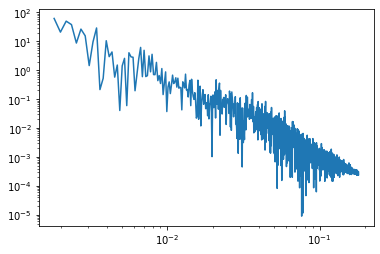

In [326]:
data_in = ds
data_all=[]
for iusv in range(1):
    ds_usv = data_in.isel(trajectory=iusv)
    ds2 = ds_usv.assign_coords(dist_total = ds_usv.dist_total)
    ds3 = ds2.swap_dims({'time':'dist_total'})
    dist_interp = np.arange(ds2.dist_total[0],ds2.dist_total[-1],0.08)
    ds4 = ds3.interp(dist_total=dist_interp)
    den = ds4.density_mean.interpolate_na(dim='dist_total')
    den = den.where(np.isfinite(den),drop=True)
    ds4_detrend = signal.detrend(den)
    ds4_detrend_smooth = scipy.ndimage.filters.gaussian_filter1d(ds4_detrend, sigma=25)
    freq, Pxx_den = signal.periodogram(ds4_detrend_smooth,1/.080)  #fs = sampled at .08km or 80m
    if iusv==0:
        data_all=ds4_detrend_smooth
        ps_all=Pxx_den[0:10000]
    else:
        data_all = np.concatenate([data_all,ds4_detrend_smooth])
        ps_all = np.vstack([ps_all,Pxx_den[0:10000]])
plt.loglog(freq[10:1000],Pxx_den[10:1000])

-2.6295554355166115


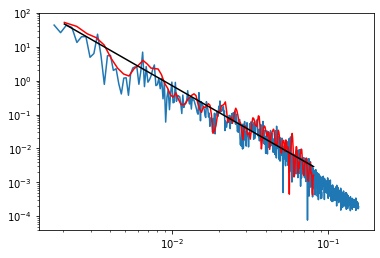

In [380]:
data_in = ds
data_all=[]
for iusv in range(1):
    ds_usv = data_in.isel(trajectory=iusv)
    ds2 = ds_usv.assign_coords(dist_total = ds_usv.dist_total)
    ds3 = ds2.swap_dims({'time':'dist_total'})
    dist_interp = np.arange(ds2.dist_total[0],ds2.dist_total[-1],0.08)
    ds4 = ds3.interp(dist_total=dist_interp)
    den = ds4.density_mean.interpolate_na(dim='dist_total')
    den = den.where(np.isfinite(den),drop=True)
    ds4_detrend = signal.detrend(den)
    ds4_detrend_smooth = scipy.ndimage.filters.gaussian_filter1d(ds4_detrend, sigma=25)
    #f, Pxx_den = signal.welch(x, fs, nperseg=1024)
    freq2, Pxx_den2 = signal.welch(ds4_detrend_smooth,1/.080,nperseg=1024*30)  #fs = sampled at .08km or 80m
#plt.loglog(freq2[10:1000],Pxx_den2[10:1000])
plt.loglog(freq[10:900],Pxx_den[10:900])
plt.loglog(freq2[5:200],Pxx_den2[5:200],'r')

#linear regression to PSD
istart,iend=5,200
XX = np.log(freq2[istart:iend])
YY = np.log(Pxx_den2[istart:iend])
reg = LinearRegression().fit(XX.reshape(-1, 1), YY)
a = float(reg.coef_)
b = -1*float(reg.intercept_)
plt.loglog(freq2[istart:iend], freq2[istart:iend]**(a)/np.exp(b),'k') #test from fit
print(a)

In [378]:
print(1/freq2[200])
print(0.08*25)

12.287999999999998
2.0


In [485]:
dir_adcp = 'C:/Users/gentemann/Google Drive/public/2019_saildrone/ATOMIC/adcp/sd-1026/'
ds_adcp = xr.open_mfdataset(dir_adcp+'*.nc',combine='nested',concat_dim='obs')
ds_adcp.close()
ds_adcp=ds_adcp.isel(trajectory=0).swap_dims({'obs':'time'})
xlat=ds_adcp.latitude
xlon=ds_adcp.longitude
dkm2 = abs(np.abs((((xlon[1:].data-xlon[0:-1].data)**2+(xlat[1:].data-xlat[0:-1].data)**2)**.5)*110.567*np.cos(np.pi*xlat[1:].data/180)))
dkm2=np.append(dkm2,dkm2[9214]) #add on last point
dkm3 = dkm2.cumsum()
ds_adcp['dist_total']=xr.DataArray(dkm3,dims=('time'),coords={'time':ds_adcp.time})
ds_adcp['dist_between']=xr.DataArray(dkm2,dims=('time'),coords={'time':ds_adcp.time})


C:\Users\gentemann\Miniconda3\envs\satenv\lib\site-packages\dask\array\core.py:1361: FutureWarning: The `numpy.append` function is not implemented by Dask array. You may want to use the da.map_blocks function or something similar to silence this warning. Your code may stop working in a future release.
  FutureWarning,


In [486]:
ds_adcp

<xarray.Dataset>
Dimensions:              (beam: 4, cell_depth: 50, time: 9216)
Coordinates:
    trajectory           int64 1026
  * cell_depth           (cell_depth) float64 4.2 6.2 8.2 ... 98.2 100.2 102.2
  * time                 (time) datetime64[ns] 2020-01-31 ... 2020-03-02T23:55:00
    latitude             (time) float64 dask.array<chunksize=(288,), meta=np.ndarray>
    longitude            (time) float64 dask.array<chunksize=(288,), meta=np.ndarray>
Dimensions without coordinates: beam
Data variables:
    roll                 (time) float64 dask.array<chunksize=(288,), meta=np.ndarray>
    pitch                (time) float64 dask.array<chunksize=(288,), meta=np.ndarray>
    heading              (time) float64 dask.array<chunksize=(288,), meta=np.ndarray>
    vel_east             (time, cell_depth) float64 dask.array<chunksize=(288, 50), meta=np.ndarray>
    vel_north            (time, cell_depth) float64 dask.array<chunksize=(288, 50), meta=np.ndarray>
    vel_up               (time, cell_depth) float64 dask.array<chunksize=(288, 50), meta=np.ndarray>
    error_vel            (time, cell_depth) float64 dask.array<chunksize=(288, 50), meta=np.ndarray>
    echo_intensity       (time, beam, cell_depth) float64 dask.array<chunksize=(288, 4, 50), meta=np.ndarray>
    correlation          (time, beam, cell_depth) float64 dask.array<chunksize=(288, 4, 50), meta=np.ndarray>
    nav_start_time       (time) datetime64[ns] dask.array<chunksize=(288,), meta=np.ndarray>
    nav_end_time         (time) datetime64[ns] dask.array<chunksize=(288,), meta=np.ndarray>
    nav_start_latitude   (time) float64 dask.array<chunksize=(288,), meta=np.ndarray>
    nav_end_latitude     (time) float64 dask.array<chunksize=(288,), meta=np.ndarray>
    nav_start_longitude  (time) float64 dask.array<chunksize=(288,), meta=np.ndarray>
    nav_end_longitude    (time) float64 dask.array<chunksize=(288,), meta=np.ndarray>
    vehicle_vel_north    (time) float64 dask.array<chunksize=(288,), meta=np.ndarray>
    vehicle_vel_east     (time) float64 dask.array<chunksize=(288,), meta=np.ndarray>
    vehicle_vel_up       (time) float64 dask.array<chunksize=(288,), meta=np.ndarray>
    bt_range             (time, beam) float64 dask.array<chunksize=(288, 4), meta=np.ndarray>
    bt_cor               (time, beam) float64 dask.array<chunksize=(288, 4), meta=np.ndarray>
    bt_vel_east          (time) float64 dask.array<chunksize=(288,), meta=np.ndarray>
    bt_vel_north         (time) float64 dask.array<chunksize=(288,), meta=np.ndarray>
    bt_vel_up            (time) float64 dask.array<chunksize=(288,), meta=np.ndarray>
    bt_amp               (time, beam) float64 dask.array<chunksize=(288, 4), meta=np.ndarray>
    bt_percent_good      (time, beam) float64 dask.array<chunksize=(288, 4), meta=np.ndarray>
    percent_good_4_beam  (time, cell_depth) float64 dask.array<chunksize=(288, 50), meta=np.ndarray>
    percent_good_3_beam  (time, cell_depth) float64 dask.array<chunksize=(288, 50), meta=np.ndarray>
    percent_good         (time, cell_depth) float64 dask.array<chunksize=(288, 50), meta=np.ndarray>
    dist_total           (time) float64 0.2751 0.754 1.1 ... 3.886e+03 3.886e+03
    dist_between         (time) float64 0.2751 0.479 0.3459 ... 0.5349 0.5349
Attributes:
    description:                     Saildrone NetCDF Format
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    keywords:                        ADCP,Saildrone
    geospatial_vertical_units:       meters
    geospatial_lon_units:            degrees_east
    geospatial_lat_units:            degrees_north
    time_coverage_resolution:        PT5M
    creator_url:                     http://saildrone.com/
    creator_name:                    Saildrone
    creator_email:                   support@saildrone.com
    date_created:                    2020-02-01T00:31:32.553490Z
    time_coverage_start:             2020-01-31T00:00:00.000Z
    time_coverage_start_unix:        1580436000

3567.339265632886 4274.542512546288
['3750', '3850', '3950', '4050', '4150', '4250', '4350']
3567.339265632886 4274.542512546288
[0.028638439698802618, 0.12418219972842859, 0.24416738674237748, 0.43895815331440563, 0.6268361930625849, 0.7585483273669917, 0.9003826688063202]


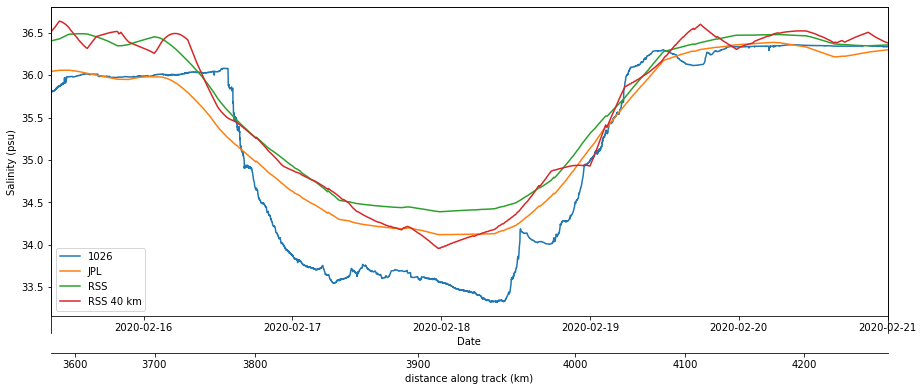

In [421]:
def ts_plot(t1,t2,var1,var2,var3,var4,ystr,figs_dir,ds_in,ds_rss_in,ds_jpl_in,str2,offset):
    import math
    iusv=0
    ds_usv = ds_in.isel(trajectory=iusv).sel(time=slice(t1,t2))
    print(ds_usv.dist_total[0].data,ds_usv.dist_total[-1].data)
    ll=[]
    for i in range(3750,4450,100):
        ll.append("{:.0f}".format(i))
    print(ll)
    fig,(ax0)= plt.subplots(1,1,figsize=(15,6))
    for iusv in range(1):
        ds_usv = ds.isel(trajectory=iusv).sel(time=slice(t1,t2))
        ax0.plot(ds_usv.time,ds_usv[var1],label=ds_usv.trajectory.data)
    ds_usv = ds_jpl_in.isel(trajectory=0).sel(time=slice(t1,t2))
    ax0.plot(ds_usv.time,ds_usv[var2]+offset,label='JPL')
    ds_usv = ds_rss_in.isel(trajectory=0).sel(time=slice(t1,t2))
    ax0.plot(ds_usv.time,ds_usv[var3]+offset,label='RSS')
    ax0.plot(ds_usv.time,ds_usv[var4]+offset,label='RSS 40 km')
    ax0.legend()
    ax0.set_ylabel(ystr)
    ax0.set_xlabel('Date')
#    ax0.set_xlim([np.datetime64(t1),np.datetime64(t2)])
    ax0.set_xlim([t1,t2])

    pos = ax0.get_position()
    pos.y0 = pos.y0+.04       # for example 0.2, choose your value
    ax0.set_position(pos)
    ax2 = ax0.twiny()
    # Move twinned axis ticks and label from top to bottom
    ax2.xaxis.set_ticks_position("bottom")
    ax2.xaxis.set_label_position("bottom")
    # Offset the twin axis below the host
    ax2.spines["bottom"].set_position(("axes", -0.06))
    ax1Ticks = ax0.get_xticks()   
    ax2Ticks = ax1Ticks
    
    #calculate new ticks
    temdist = ds_usv.dist_total.data
    print(ds_usv.dist_total[0].data,ds_usv.dist_total[-1].data)
    tem = np.arange(math.ceil(ds_usv.dist_total[0].data/50)*50,math.floor(ds_usv.dist_total[-1].data/50)*50+60,100)
    ll=[]
    for i in tem: #range(3750,4450,100):
        ll.append("{:.0f}".format(i))
    isv=[]
    for i in tem:
        ii = np.argwhere((ds_usv.dist_total.data.astype(int))==i)
        if len(ii)>0:
            isv.append(int(ii.mean())/len(temdist))   
    
    new_tick_locations = isv
    print(new_tick_locations)
    ax2.set_xticks(new_tick_locations)
    ax2.set_xticklabels(ll)
    ax2.set_xlabel('distance along track (km)')
    #plt.savefig(figs_dir+ 'timeseries_'+str(t1)+'eddy'+str2+'.png')

t1,t2 = np.datetime64('2020-02-15T09'),np.datetime64('2020-02-21T00')
offset=0
var1,var2,var3,var4,ystr= 'SAL_SBE37_MEAN','smap_sss','sss_smap','sss_smap_40km','Salinity (psu)'
ts_plot(t1,t2,var1,var2,var3,var4,ystr,figs_dir,ds_saildrone,ds_rss_usv,ds_jpl_usv,'salinity',offset)

3567.339265632886 4274.542512546288
['3750', '3850', '3950', '4050', '4150', '4250', '4350']


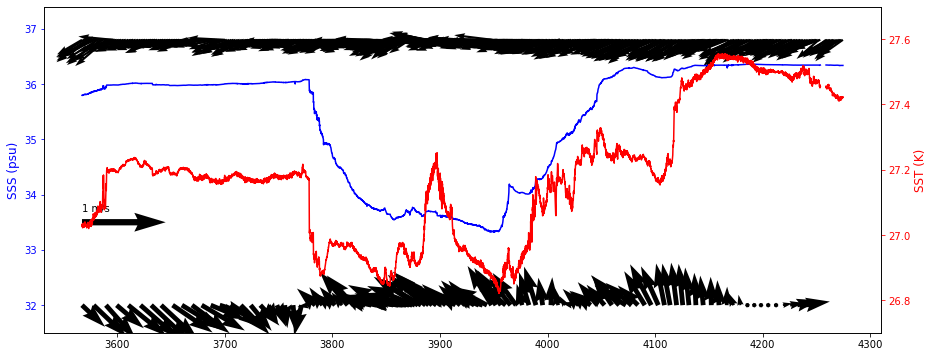

In [561]:

t1,t2 = np.datetime64('2020-02-15T09'),np.datetime64('2020-02-21T00')
offset=0
var1,var2,var3,var4,ystr= 'SAL_SBE37_MEAN','smap_sss','sss_smap','sss_smap_40km','Salinity (psu)'
#ts_plot(t1,t2,var1,var2,var3,var4,ystr,figs_dir,ds_saildrone,ds_rss_usv,ds_jpl_usv,'salinity',offset)
#tem=ds_saildrone.sel(time=slice(t1,t2))

#tem = ds_adcp.sel(time=slice(t1,t2))
import math
iusv=0
 
ds_usv = ds_saildrone.isel(trajectory=iusv).sel(time=slice(t1,t2))
print(ds_usv.dist_total[0].data,ds_usv.dist_total[-1].data)
ll=[]
for i in range(3750,4450,100):
    ll.append("{:.0f}".format(i))
print(ll)
fig,(ax0)= plt.subplots(1,1,figsize=(15,6))
ds_usv = ds.isel(trajectory=iusv).sel(time=slice(t1,t2))
ax0.plot(ds_usv.dist_total,ds_usv[var1],'b',label=var1)

ds_tem = ds_adcp.sel(time=slice(t1,t2))
rx = ds_tem.dist_total-ds_tem.dist_total[0]+ds_usv.dist_total[0]
rx = rx[::15]
ry=np.ones(len(rx))*32
dx,dy = ds_tem.vel_east[::15,0], ds_tem.vel_north[::15,0]
ax0.quiver(rx,ry,dx,dy,scale=10)

rx = ds_usv.dist_total
rx = rx[::15]
ry=np.ones(len(rx))*36.8
dx,dy = ds_usv.UWND_MEAN[::15], ds_usv.VWND_MEAN[::15]
ax0.quiver(rx,ry,dx,dy,scale=200)

#add scale arrow
ax0.quiver(ds_usv.dist_total[0],33.5,1,0,scale=10)
ax0.text(ds_usv.dist_total[0],33.7,'1 m/s')
ax0.set_ylim([31.5,37.4])

ax0a=ax0.twinx()
ax0a.plot(ds_usv.dist_total,ds_usv.TEMP_SBE37_MEAN,'r',label='SST')
#ax0a.plot(ds_usv.dist_total,ds_usv.TEMP_AIR_MEAN,'r',label='Air')
ax0a.set_ylim([26.7,27.7])
ax0a.set_ylabel('SST (K)',color='r',fontsize=12)
ax0a.tick_params(axis='y', colors='red')
ax0.set_ylabel('SSS (psu)',color='b',fontsize=12)
ax0.tick_params(axis='y', colors='b')





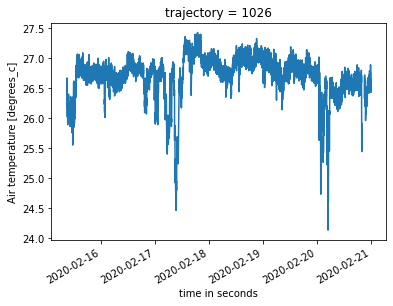

In [547]:
ds_usv.TEMP_AIR_MEAN.plot()

In [449]:
tem.time[0:10].values

array(['2020-02-15T09:00:00.000000000', '2020-02-15T09:05:00.000000000',
       '2020-02-15T09:10:00.000000000', '2020-02-15T09:15:00.000000000',
       '2020-02-15T09:20:00.000000000', '2020-02-15T09:25:00.000000000',
       '2020-02-15T09:30:00.000000000', '2020-02-15T09:35:00.000000000',
       '2020-02-15T09:40:00.000000000', '2020-02-15T09:45:00.000000000'],
      dtype='datetime64[ns]')

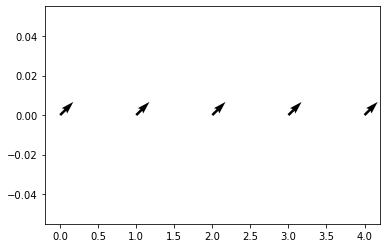

In [470]:
#plt.arrow([0,1],[0, 0],[0.5,0.5],[0.5,0.5], head_width=0.05, head_length=0.1, fc='k', ec='k')
plt.quiver([0,1,2,3,4],[0,0,0,0,0],np.ones(5)*.5,np.ones(5)*.5)


In [555]:
ds_usv

<xarray.Dataset>
Dimensions:                         (time: 8101)
Coordinates:
  * time                            (time) datetime64[ns] 2020-02-15T09:00:00 ... 2020-02-21
    latitude                        (time) float64 11.8 11.8 11.8 ... 9.769 9.77
    longitude                       (time) float64 -58.95 -58.95 ... -54.52
    trajectory                      <U4 '1026'
Data variables:
    SOG                             (time) float64 1.719 2.203 ... 1.471 1.621
    SOG_FILTERED_MEAN               (time) float64 2.184 1.922 ... 1.423 1.399
    SOG_FILTERED_STDDEV             (time) float64 0.385 0.252 ... 0.338 0.29
    SOG_FILTERED_MAX                (time) float64 3.009 2.59 ... 2.241 1.995
    SOG_FILTERED_MIN                (time) float64 1.303 1.303 ... 0.531 0.871
    COG                             (time) float64 137.4 139.5 ... 342.6 331.0
    COG_FILTERED_MEAN               (time) float64 139.3 136.0 ... 345.0 345.9
    COG_FILTERED_STDDEV             (time) float64 11.2 14.1 12.8 ... 19.4 20.6
    HDG                             (time) float64 134.8 138.7 ... 341.6 328.9
    HDG_FILTERED_MEAN               (time) float64 135.1 136.3 ... 341.8 328.6
    HDG_FILTERED_STDDEV             (time) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ROLL_FILTERED_MEAN              (time) float64 3.4 -3.4 12.4 ... -1.4 2.4
    ROLL_FILTERED_STDDEV            (time) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    ROLL_FILTERED_PEAK              (time) float64 3.4 -3.4 12.4 ... -1.4 2.4
    PITCH_FILTERED_MEAN             (time) float64 -3.9 0.8 -3.3 ... -1.8 2.0
    PITCH_FILTERED_STDDEV           (time) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    PITCH_FILTERED_PEAK             (time) float64 -3.9 0.8 -3.3 ... -1.8 2.0
    HDG_WING                        (time) float64 79.5 86.6 94.2 ... 31.2 29.2
    WING_HDG_FILTERED_MEAN          (time) float64 86.6 82.5 87.6 ... 38.1 34.4
    WING_HDG_FILTERED_STDDEV        (time) float64 3.8 4.5 4.0 ... 4.5 3.6 4.8
    WING_ROLL_FILTERED_MEAN         (time) float64 3.9 3.0 4.2 ... -1.6 -1.5
    WING_ROLL_FILTERED_STDDEV       (time) float64 4.7 4.7 5.3 ... 4.5 5.0 4.4
    WING_ROLL_FILTERED_PEAK         (time) float64 nan nan nan ... nan nan nan
    WING_PITCH_FILTERED_MEAN        (time) float64 3.5 2.4 3.4 ... 3.0 2.3 2.4
    WING_PITCH_FILTERED_STDDEV      (time) float64 4.2 4.9 5.6 ... 6.8 5.7 5.6
    WING_PITCH_FILTERED_PEAK        (time) float64 18.5 13.4 19.5 ... 14.9 15.5
    WING_ANGLE                      (time) float64 -55.4 -52.2 ... 49.7 60.3
    UWND_MEAN                       (time) float64 -5.96 -6.58 ... -5.34 -5.35
    UWND_STDDEV                     (time) float64 0.57 0.78 0.56 ... 0.42 0.63
    VWND_MEAN                       (time) float64 -3.49 -3.74 ... -3.11 -3.78
    VWND_STDDEV                     (time) float64 0.53 0.53 0.57 ... 0.37 0.53
    WWND_MEAN                       (time) float64 -0.19 -0.16 ... -0.11 -0.1
    WWND_STDDEV                     (time) float64 0.4 0.48 0.39 ... 0.31 0.33
    GUST_WND_MEAN                   (time) float64 8.76 8.91 8.42 ... 6.85 7.56
    GUST_WND_STDDEV                 (time) float64 0.54 0.61 0.43 ... 0.3 0.57
    WIND_MEASUREMENT_HEIGHT_MEAN    (time) float64 4.966 4.927 ... 4.95 4.96
    WIND_MEASUREMENT_HEIGHT_STDDEV  (time) float64 0.043 0.088 ... 0.058 0.059
    TEMP_AIR_MEAN                   (time) float64 26.42 26.63 ... 26.45 26.5
    TEMP_AIR_STDDEV                 (time) float64 0.17 0.07 0.02 ... 0.06 0.02
    RH_MEAN                         (time) float64 76.73 76.08 ... 75.59 75.08
    RH_STDDEV                       (time) float64 0.82 0.75 0.37 ... 0.57 0.33
    BARO_PRES_MEAN                  (time) float64 1.014e+03 ... 1.013e+03
    BARO_PRES_STDDEV                (time) float64 0.09 0.09 0.08 ... 0.07 0.09
    PAR_AIR_MEAN                    (time) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    PAR_AIR_STDDEV                  (time) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    TEMP_IR_SEA_WING_UNCOMP_MEAN    (time) float64 26.67 26.6